In [1]:
'packages'
from PIL import Image
from skimage import io, measure
from scipy import ndimage
import os, glob, cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage import exposure
from skimage.measure import label, regionprops
from skimage.util import montage
import math
import shutil
import pandas as pd
from skimage.morphology import binary_erosion, binary_dilation, disk, remove_small_objects
import scipy
from scipy.signal import find_peaks

In [2]:
import session_info

session_info.show()

In [3]:
#------------------------------- comet preprocessing functions --------------------------
def read_files(path,identifier, verbose=True):
    '''
    function to read tif images from path
    Input: image path, identifier = file extension
    Return image file list
    '''
    filelist = sorted(
        glob.glob(os.path.join(path, '*'+identifier+'*'), recursive=True))
    if verbose:
        print(filelist)
    return filelist


def image_preprocess(image, degree = 0, flip = False):
    '''
    degree = image rotation, flip = flip image vertically
    Return processed image
    '''
    if flip:
        image = cv2.flip(image, 0) 
    if degree != 0:
        image = ndimage.rotate(image, degree)
    return image


def image_preview(filelist_in, degree, flip, num_images=5):
    '''
    function to preview images if needed
    default to show the first 5 original and preprocessed image
    '''
    for idx in range(1,num_images):
        img_path = filelist_in[idx]
        img = cv2.imread(img_path,0)
        img_original = img.copy()
        
        img = image_preprocess(img, degree, flip)
            
        fig, ax = plt.subplots(1,2, figsize=(10, 10), sharex=True, sharey=True)
        ax[0].imshow(img_original, cmap=plt.cm.gray)
        ax[0].autoscale(False)
        ax[0].axis('off')
        ax[0].set_title('Original') 
        ax[1].imshow(img, cmap=plt.cm.gray)
        ax[1].autoscale(False)
        ax[1].axis('off')
        ax[1].set_title('Processed Images')
        
        
def object_segment(filelist_in, degree, flip, binary_thresh = 50, min_area = 30, max_area = 5000, plot_graph = False):
    '''
    read the image 
    perform necessary filping/rotation
    perform binary thresholding to segment image and keep objects that are within reasonable size

    Input: image file list, minimum/maximum pixel area of comet objects
    Return array containing segmented image, original image, image path
    '''
    
    img_segment_all = []
    
    for idx in range(1,len(filelist_in)):
        img_path = filelist_in[idx]

        img = cv2.imread(img_path,0)
        img_original = img.copy()
        
        #perform preprocessing
        img = image_preprocess(img, degree, flip)
        
        #perform segmentation
        img = exposure.rescale_intensity(img)
        gray = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        _,thresh = cv2.threshold(gray, binary_thresh, 255, cv2.THRESH_BINARY)

        label_image = measure.label(thresh, connectivity=2, background=0)
        regions = regionprops(label_image)
        totalarea = cv2.countNonZero(label_image)
        labels = label_image.copy()

        #filter images that contain huge total area (consider as bad intensity image)
        BAD_TOTAL_INT = 100000
        if(totalarea < BAD_TOTAL_INT):
            for region in regions:
                region_area = float(region.area)

                if not (min_area < region_area < max_area):
                    labels[np.isin(labels, region.label)] = 0

            img_segment_all.append([labels,img,img_path])

            if(plot_graph):
                fig, ax = plt.subplots(1,4, figsize=(10, 10), sharex=True, sharey=True)
                ax[0].imshow(img_original, cmap=plt.cm.gray)
                ax[0].autoscale(False)
                ax[0].axis('off')
                ax[0].set_title('Original') 
                ax[1].imshow(img, cmap=plt.cm.gray)
                ax[1].autoscale(False)
                ax[1].axis('off')
                ax[1].set_title('Processed Images')
                ax[2].imshow(thresh, cmap=plt.cm.gray)
                ax[2].autoscale(False)
                ax[2].axis('off')
                ax[2].set_title('Segmented Mask')
                ax[3].imshow(labels, cmap=plt.cm.gray)
                ax[3].autoscale(False)
                ax[3].axis('off')
                ax[3].set_title('Filtered Labels')
                fig.tight_layout()
                plt.show()
            
    return img_segment_all

def object_info(filelist_in):
    '''
    Go through each segmented object and store object infos, 
    Return [file, img array ,segment mask array, label objectid, y coordinate,x coordinate, minr, minc, maxr, maxc]
    '''
    img_labels_all = []
    img_info_all = []
    for idx in range(1,len(filelist_in)):
        label_image = filelist_in[idx][0]
        regions = regionprops(label_image)
        
        labels = label_image.copy()

        for region in regions:
            y0, x0 = region.centroid
            minr, minc, maxr, maxc = region.bbox

            tmp_info=[filelist_in[idx][2], filelist_in[idx][1], filelist_in[idx][0], region.label, y0, x0, minr, minc, maxr, maxc]    
            img_info_all.append(tmp_info)

    return img_info_all

In [4]:
#------------------------------- comet segmentation and filtering functions --------------------------
def object_params(img_info_all, idx):
    '''
    To extract individual cell info
    '''
    file = img_info_all[idx][0]
    img = img_info_all[idx][1]
    labels = img_info_all[idx][2]
    objectid = img_info_all[idx][3]
    minr = img_info_all[idx][6]
    minc = img_info_all[idx][7]
    maxr = img_info_all[idx][8]
    maxc = img_info_all[idx][9]
    return file, img, labels, objectid, minr, minc, maxr, maxc

def object_cropping(image_in, minr, minc, maxr, maxc, crop_dim):
    '''
    To crop images to user crop dimension
    Return individual crop
    '''
    h = crop_dim[0]
    w = crop_dim[1]
 
    if((maxc - minc) < w):
        diff = int(w - (maxc - minc))
        new_maxc = int(maxc + (diff/2))
        new_minc = int(minc - (diff/2))
    if((maxr - minr < h)):
        diff = int(h - (maxr - minr))
        new_maxr = int(maxr + diff - 10)
        new_minr = int(minr - 10)
        
    crop = image_in[new_minr:new_maxr, new_minc:new_maxc]

    return crop

def get_crops(data, idx):
    '''
    get crop file name, label, and perform cropping
    '''
    file, img, labels, objectid, minr, minc, maxr, maxc = object_params(data, idx)

    cropped_label = object_cropping(labels, minr, minc, maxr, maxc, crop_dim)
    cropped_img = object_cropping(img, minr, minc, maxr, maxc, crop_dim)
    return file, labels, objectid, cropped_img, cropped_label


def filter_extra_labels_and_edge(data, crop_dim, verbose=True):
    '''
    First round of filtering
    Filter labels that appears in more than one crop and on edge
    Return list with filename, objectid, cropped image, and cropped segment image'''
    filter_labels_list=[]
    for idx in range(len(data)):

        file, labels, objectid, cropped_img, cropped_label = get_crops(data, idx)

        #filter images on edge
        if cropped_label.shape == crop_dim and cropped_img.shape == crop_dim:

            #find labels that appears in more than one crop
            filter_labels = np.unique(cropped_label)[2:]
            if (len(filter_labels) >= 1):
                for i in range(len(filter_labels)):
                    filters = [file,filter_labels[i]]
                    filter_labels_list.append(filters)
                    
    #remove filtered labels from list 
    print('Original length:', len(data))
    for idx,info in enumerate(filter_labels_list):
        for ele in data[:]:
            if(ele[0] == info[0] and ele[3] == info[1]):
                data.remove(ele)
    
    #Filter edge images
    filelist_out = []
    for idx in range(len(data)):

        file, labels, objectid, cropped_img, cropped_label = get_crops(data, idx)

        if cropped_label.shape == crop_dim and cropped_img.shape == crop_dim:
            final=[file, objectid, cropped_img,cropped_label]
            filelist_out.append(final)

    print('Filtered length:', len(filelist_out))
    return filelist_out

In [5]:
#------------------------------- comet measurement functions --------------------------
def head_body_segment(cropped_img, cropped_label, head_min = 30, body_min = 80, lowerthresh = 35, upperthresh=185):
    '''
    segment head and body in crop
    Perform erosion and dilation to the head segment
    Remove tiny objects from the segmentation
    Return: Crop, body mask, head mask, head labels, body labels 
    '''
    img = exposure.rescale_intensity(cropped_img)
    img = exposure.equalize_adapthist(img,clip_limit=0.008)
    gray = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    #detect head and body
    _,head_thresh = cv2.threshold(gray, upperthresh,255,cv2.THRESH_BINARY)
    _,body_thresh = cv2.threshold(gray, lowerthresh,255,cv2.THRESH_BINARY)

    #perfrom dilation on head
    ITERATION=10
    head_thresh = binary_erosion(head_thresh)
    head_thresh = binary_dilation(head_thresh)
    head_thresh = scipy.ndimage.morphology.binary_dilation(head_thresh,iterations=ITERATION)

    #remove some tiny objects
    head_label, heads = scipy.ndimage.measurements.label(head_thresh)
    body_label, bodies = scipy.ndimage.measurements.label(body_thresh)
    body_label = remove_small_objects(body_label,body_min)
    head_label = remove_small_objects(head_label,head_min)

    head_regions = regionprops(head_label, intensity_image = gray)
    body_regions = regionprops(body_label, intensity_image = gray)
    
    return gray, body_label, head_label, head_regions, body_regions

def comet_filter_location(info, tmp, labels, obj, filter_object, head_tail_dist = 0.5):
    ''' 
    Second round of filter mainly based on comet objects location
    Filter comet heads that are further to the top of the crop;
    Filter comet body that has more than one segmented objects, 
        and are huge, and are very far away from each other 
    '''
    
    ob_filter = False
    
    if(filter_object == 'Head' and len(info)>0):
        #keep the higher head (compare the top of head segments location)
        if tmp[4] > info[0][4]:
            labels[np.isin(labels, obj)] = 0
            ob_filter = True
    
    if(filter_object == 'Body' and len(info) >0):
        #if more than 1 body segmentation object is larger than 2000, assumming > 1 real comet
        COMET_SIZE = 2000
        if tmp[0] > COMET_SIZE and info[0][0] > COMET_SIZE:
            if tmp[5] > info[0][5]:
                labels[np.isin(labels, obj)] = 0
                ob_filter = True
            else:
                #keep the one appeared higher
                labels[np.isin(labels, obj) == False] = 0
                info=[]
                info.append(tmp)
                
        #if 2 body segmented object are far away(more than half crop distance) from each other
        if abs(tmp[4] - info[0][4] > (crop_dim[0] * head_tail_dist)):
            if tmp[5] > info[0][5]:
                labels[np.isin(labels, obj)] = 0
                ob_filter = True
            else:
                #keep the one appeared higher
                labels[np.isin(labels, obj) == False] = 0
                info=[]
                info.append(tmp)
    
    return ob_filter, labels, info

def comet_info(labels, regions, area_min, area_max, filter_object):
    '''
    find comet basic infos and replace area that are outside min/max with black pixels for each comet
    '''
    info = []
    ob_filter = False
    
    for region in regions:
        if( area_min < region.area < area_max):
            y0, x0 = region.centroid
            minr, minc, maxr, maxc = region.bbox
            mid = maxc - minc
            cir = 4*math.pi*(region.area/(region.perimeter*region.perimeter))
            tmp = [region.area, region.mean_intensity, region.major_axis_length, x0, minr, maxr, mid, (region.area*region.mean_intensity), cir]         
            
            obj = region.label
            
            #perform second round filtering
            ob_filter, labels, info = comet_filter_location(info, tmp, labels, obj, filter_object, head_tail_dist = 0.3)

            if not ob_filter:
                info.append(tmp)
        else:
            labels[np.isin(labels, region.label)] = 0

    return labels, info


def comet_calculations(file, label, img, head_label, body_label, comet_head_info, comet_body_info, verbose = True, plot_graph=True):
    '''calculate comets statistics, includes:
    comet head length, comet tail length, comet body length,
    comet area, comet dna content, comet average intensity,
    head area, head dna content, head average intensity, head dna percentage,
    tail_area, tail dna content, tail average intensity, tail dna percentage
    Return list of statistics for each comet crop
    '''
    
    stats = []
    
    comet_area = sum(map(lambda x: x[0], comet_body_info))
    head_area = sum(map(lambda x: x[0], comet_head_info))
    body_cir_count = len(list(filter(lambda x: x[8] > 0.9, comet_body_info)))
    
    if len(comet_head_info) > 0 and len(comet_body_info)>0 and comet_area > head_area:
        if not len(comet_body_info) > 4 or body_cir_count > 1:

            #bottom(maxr) of the higher head location, end of comet head/start of comet tail
            head_bottom= min(map(lambda x: x[5], comet_head_info))
            #top(minr) of the higher head location, start of comet head
            head_top = min(map(lambda x: x[4], comet_head_info))

            #bottom(maxr)of the body location,end of comet tail
            body_bottom= max(map(lambda x: x[5], comet_body_info))
            #bottom of the higher body(usually the head) location
            high_body_bottom = min(map(lambda x: x[5], comet_body_info))

            #in case of more than objects
            #x coordinate of comet head
            head_x = np.mean(comet_head_info, axis=0)[3]
            #avergae x cooridinate of comet bodies
            body_x = np.mean(comet_body_info, axis=0)[3]

            #filter if comet body might appear higher than comet head
            dif = high_body_bottom - head_top 
            if(dif <0):
                return

            #---Calculations
            bodylength = body_bottom - head_top 

            if(body_bottom >= head_bottom):
                taillength = body_bottom - head_bottom
                # find tail pixel intensities and filter in cases when body and head are far away in odd locations
                # and potentially has low intensity
                head_x_int, head_y_int = np.linspace(head_x, body_x, (bodylength)), np.linspace(head_top, body_bottom, (bodylength))
                top_zi = scipy.ndimage.map_coordinates(np.transpose(img), np.vstack((head_x_int,head_y_int)))
                if(np.mean(top_zi) < 40):
                    return
            else:
                taillength=0

            head_length = bodylength - taillength
            head_length = bodylength - taillength
            comet_dna_content = sum(map(lambda x: x[7], comet_body_info))
            comet_avg_int = comet_dna_content/comet_area
            head_dna_content = sum(map(lambda x: x[7],comet_head_info))
            head_avg_int = head_dna_content / head_area
            head_dna_percentage = (head_dna_content / comet_dna_content) * 100
            tail_area = comet_area - head_area
            tail_dna_content = comet_dna_content - head_dna_content
            tail_average = tail_dna_content / tail_area
            tail_dna_percentage = (tail_dna_content/comet_dna_content) * 100

            if(tail_dna_percentage > 0):
                if plot_graph:
                    fig, ax =  plt.subplots(1,3, figsize=(4, 4), sharex=True, sharey=True)
                    ax[0].imshow(img, cmap='gray')
                    ax[0].plot([head_x, body_x], [head_bottom, body_bottom], 'ro-')
                    ax[0].plot([head_x+5, body_x+5], [head_top, body_bottom], 'bo-')
                    ax[0].axis('off')
                    ax[0].axis('image')
                    ax[1].imshow(head_label, cmap='gray')
                    ax[1].axis('off')
                    ax[1].set_title('Head')
                    ax[2].imshow(body_label, cmap='gray')
                    ax[2].axis('off')
                    ax[2].set_title('Body')

                    fig.tight_layout()
                    plt.show()
                    
                if verbose:
                    print('Head length: ', head_length)
                    print('Tail length: ',  taillength)
                    print('Body length: ',  bodylength)
                    print('Comet area: ', comet_area)
                    print('Comet DNA content: ', comet_dna_content)
                    print('Comet average intensity: ', comet_avg_int)
                    print('Head area: ', head_area)
                    print('Head DNA content: ', head_dna_content)
                    print('Head average intensity: ', head_avg_int)
                    print('Head DNA %: ',  head_dna_percentage)
                    print('Tail area: ', tail_area)
                    print('Tail DNA content: ', tail_dna_content)
                    print('Tail average intensity: ', tail_average)
                    print('Tail DNA %: ', tail_dna_percentage)

                stats = [file, label, head_length, taillength, bodylength, comet_area, comet_dna_content, comet_avg_int,head_area, head_dna_content,head_avg_int,head_dna_percentage, tail_area, tail_dna_content,tail_average,tail_dna_percentage]

    return stats


def comet_measure(data, head_min=200, body_min=300, head_max=3500, body_max=20000, plot_graph=True):
    '''
    Detect comet body and head
    Filter comets with certain criterias such as area, circularity,number of objects
    Measure and return comet statistics
    '''
    
    all_img = []
    all_stats = []
    for idx in range(1, len(data)):
        final_stats=[]

        file = data[idx][0]
        objectid = data[idx][1]
        cropped_img = data[idx][2]
        cropped_label = data[idx][3]
        
        #perform segmentation
        img, body_label, head_label, head_regions, body_regions = head_body_segment(cropped_img, cropped_label)

        #perform necessary comet head and body filters 
        if(len(np.unique(body_label)) < 4 and  1 < len(np.unique(head_label)) < 4):
                
            head_label, head_info = comet_info(head_label, head_regions, area_min = head_min, area_max = head_max, filter_object= 'Head')
            body_label, body_info = comet_info(body_label, body_regions, area_min = body_min, area_max = body_max, filter_object= 'Body')
                
            #perform final filtering and calculation
            stats = comet_calculations(file, objectid, img, head_label, body_label, head_info, body_info, plot_graph)
            
            if stats:
                all_stats.append(stats)
                all_img.append(np.asarray(cropped_img))
                            
    return all_stats, all_img

In [6]:
#------------------------------- comet output functions --------------------------
def class_montage(imgs,w,h,rescale=True):
    '''
    Put comet crops together as montage
    '''
    plt.figure(figsize = (w,h))
    plt.imshow(montage(np.array(imgs),rescale_intensity=rescale),cmap=plt.cm.gray)

## Input Parameters and preprocessing

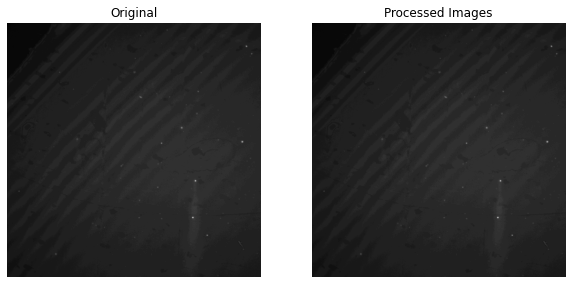

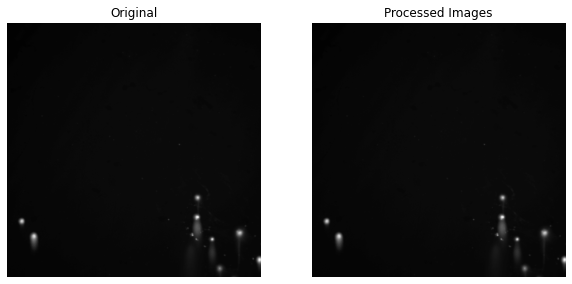

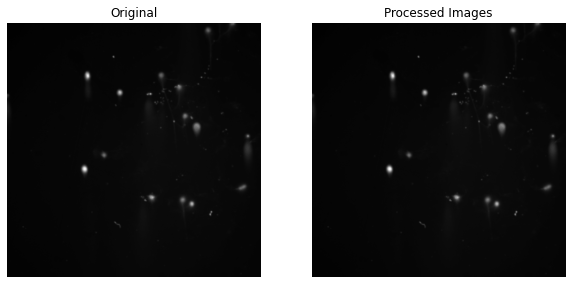

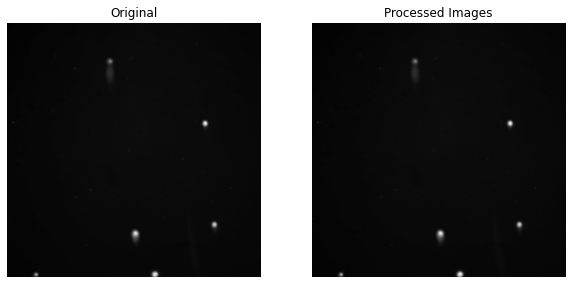

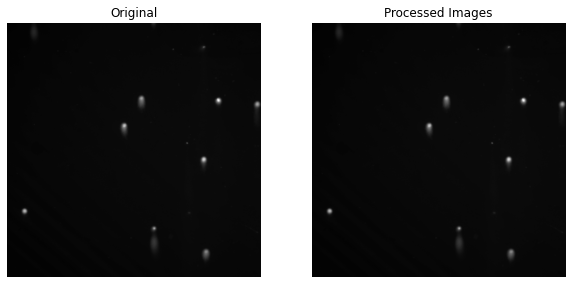

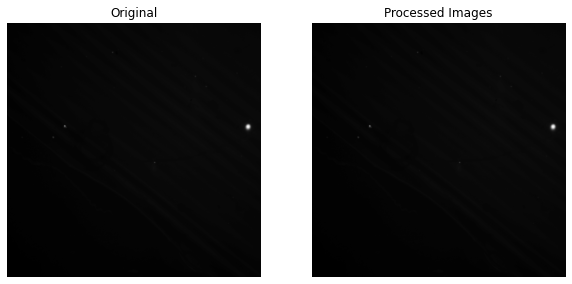

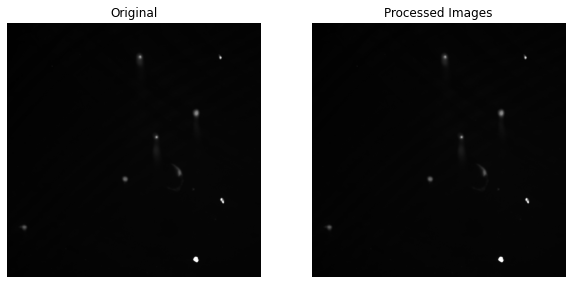

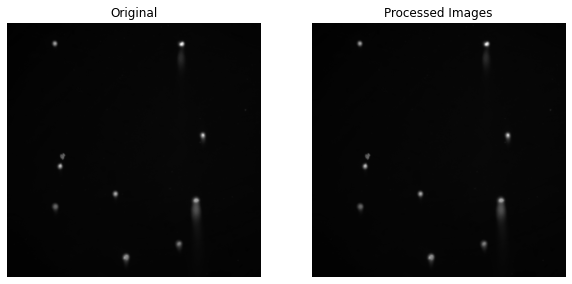

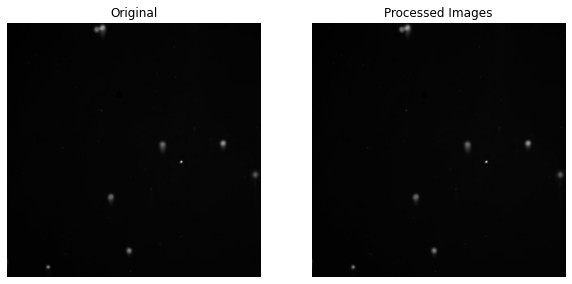

In [7]:
#input and output paths
input_path = "/Volumes/My Passport for Mac/CometAssay/Condition#1"
output_path='/Volumes/My Passport for Mac/CometAssay/OutputCrops'
#flip image so that comets appear from top to bottom if necessary
image_fipping = False
#rotate images to different degrees if necessary
image_rotation = 0
#crop size
crop_dim = (278, 143)
preview = True

#read in files, set verbose = True to see filelist
img_filelist = read_files(input_path, 'tif', verbose=False)

#preview images to see if preprocessing is needed
if preview:
    image_preview(img_filelist, image_rotation, image_fipping, num_images=10)

### comet segmentation and filtering

In [8]:
#find comets
img_segments_all = object_segment(img_filelist, image_rotation, image_fipping, min_area = 30, max_area = 7000)

#crop and filter comets
img_info_all = object_info(img_segments_all)
filtered_info = filter_extra_labels_and_edge(img_info_all, crop_dim)

Original length: 371
Filtered length: 188


### Comet Measurement

<ipython-input-5-b546c8061606>:27: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  head_label = remove_small_objects(head_label,head_min)


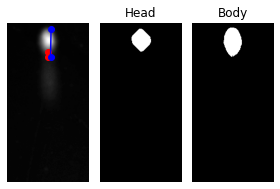

Head length:  40
Tail length:  9
Body length:  49
Comet area:  1204
Comet DNA content:  138430.0
Comet average intensity:  114.97508305647841
Head area:  910
Head DNA content:  122032.99999999999
Head average intensity:  134.1021978021978
Head DNA %:  88.15502419995664
Tail area:  294
Tail DNA content:  16397.000000000015
Tail average intensity:  55.77210884353747
Tail DNA %:  11.844975800043352


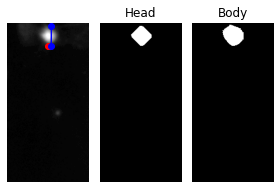

Head length:  35
Tail length:  0
Body length:  35
Comet area:  967
Comet DNA content:  111431.0
Comet average intensity:  115.23371251292657
Head area:  775
Head DNA content:  102235.0
Head average intensity:  131.91612903225806
Head DNA %:  91.74735935242437
Tail area:  192
Tail DNA content:  9196.0
Tail average intensity:  47.895833333333336
Tail DNA %:  8.25264064757563


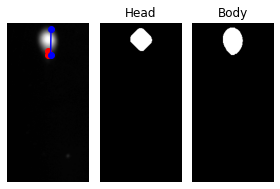

Head length:  40
Tail length:  7
Body length:  47
Comet area:  1267
Comet DNA content:  156129.0
Comet average intensity:  123.22730860299922
Head area:  1013
Head DNA content:  141764.0
Head average intensity:  139.9447186574531
Head DNA %:  90.79927495852789
Tail area:  254
Tail DNA content:  14365.0
Tail average intensity:  56.55511811023622
Tail DNA %:  9.200725041472117


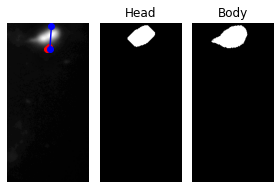

Head length:  38
Tail length:  2
Body length:  40
Comet area:  1597
Comet DNA content:  180298.0
Comet average intensity:  112.8979336255479
Head area:  1142
Head DNA content:  157479.0
Head average intensity:  137.89754816112085
Head DNA %:  87.34373093434203
Tail area:  455
Tail DNA content:  22819.0
Tail average intensity:  50.151648351648355
Tail DNA %:  12.656269065657966


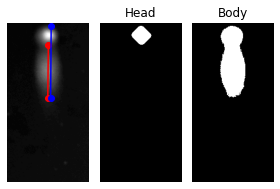

Head length:  33
Tail length:  92
Body length:  125
Comet area:  4271
Comet DNA content:  344291.0
Comet average intensity:  80.61133224069305
Head area:  725
Head DNA content:  96160.0
Head average intensity:  132.6344827586207
Head DNA %:  27.929861657725585
Tail area:  3546
Tail DNA content:  248131.0
Tail average intensity:  69.97490129723633
Tail DNA %:  72.07013834227442


<ipython-input-5-b546c8061606>:26: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  body_label = remove_small_objects(body_label,body_min)


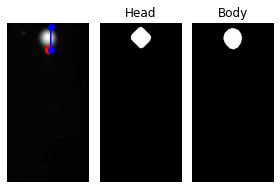

Head length:  37
Tail length:  2
Body length:  39
Comet area:  899
Comet DNA content:  110838.0
Comet average intensity:  123.29032258064517
Head area:  837
Head DNA content:  107115.0
Head average intensity:  127.97491039426524
Head DNA %:  96.64104368537866
Tail area:  62
Tail DNA content:  3723.0
Tail average intensity:  60.04838709677419
Tail DNA %:  3.3589563146213393


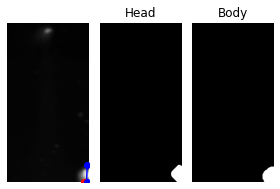

Head length:  30
Tail length:  0
Body length:  30
Comet area:  452
Comet DNA content:  56656.0
Comet average intensity:  125.34513274336283
Head area:  431
Head DNA content:  54151.0
Head average intensity:  125.64037122969837
Head DNA %:  95.57857949731714
Tail area:  21
Tail DNA content:  2505.0
Tail average intensity:  119.28571428571429
Tail DNA %:  4.421420502682858


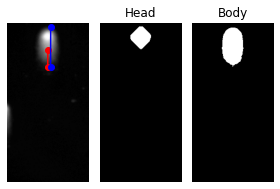

Head length:  40
Tail length:  30
Body length:  70
Comet area:  1993
Comet DNA content:  218081.0
Comet average intensity:  109.4234821876568
Head area:  917
Head DNA content:  131662.0
Head average intensity:  143.57906215921483
Head DNA %:  60.372980681489906
Tail area:  1076
Tail DNA content:  86419.0
Tail average intensity:  80.31505576208178
Tail DNA %:  39.627019318510094


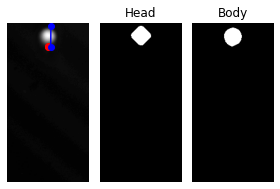

Head length:  34
Tail length:  2
Body length:  36
Comet area:  767
Comet DNA content:  93771.0
Comet average intensity:  122.25684485006519
Head area:  763
Head DNA content:  91860.0
Head average intensity:  120.39318479685453
Head DNA %:  97.96205649934416
Tail area:  4
Tail DNA content:  1911.0
Tail average intensity:  477.75
Tail DNA %:  2.037943500655853


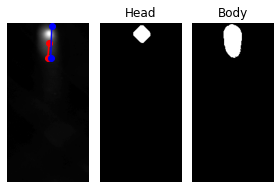

Head length:  31
Tail length:  26
Body length:  57
Comet area:  1496
Comet DNA content:  120070.0
Comet average intensity:  80.26069518716578
Head area:  603
Head DNA content:  71300.0
Head average intensity:  118.24212271973467
Head DNA %:  59.382027150828684
Tail area:  893
Tail DNA content:  48770.0
Tail average intensity:  54.61366181410974
Tail DNA %:  40.617972849171316


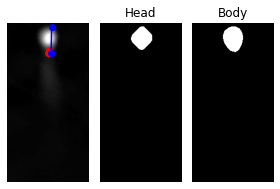

Head length:  41
Tail length:  4
Body length:  45
Comet area:  1198
Comet DNA content:  150104.0
Comet average intensity:  125.29549248747914
Head area:  1023
Head DNA content:  140831.0
Head average intensity:  137.66471163245356
Head DNA %:  93.82228321696957
Tail area:  175
Tail DNA content:  9273.0
Tail average intensity:  52.988571428571426
Tail DNA %:  6.177716783030432


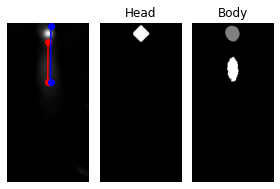

Head length:  29
Tail length:  70
Body length:  99
Comet area:  1151
Comet DNA content:  76035.0
Comet average intensity:  66.05994787141616
Head area:  473
Head DNA content:  47617.0
Head average intensity:  100.67019027484143
Head DNA %:  62.6251068586835
Tail area:  678
Tail DNA content:  28418.0
Tail average intensity:  41.91445427728613
Tail DNA %:  37.3748931413165


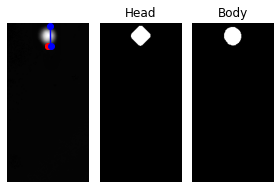

Head length:  35
Tail length:  0
Body length:  35
Comet area:  754
Comet DNA content:  93300.0
Comet average intensity:  123.74005305039788
Head area:  751
Head DNA content:  92148.0
Head average intensity:  122.70039946737683
Head DNA %:  98.7652733118971
Tail area:  3
Tail DNA content:  1152.0
Tail average intensity:  384.0
Tail DNA %:  1.2347266881028938


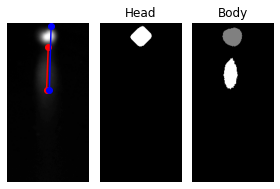

Head length:  36
Tail length:  75
Body length:  111
Comet area:  1797
Comet DNA content:  145487.0
Comet average intensity:  80.96104618809126
Head area:  833
Head DNA content:  102099.0
Head average intensity:  122.56782713085234
Head DNA %:  70.1774041666953
Tail area:  964
Tail DNA content:  43388.0
Tail average intensity:  45.00829875518672
Tail DNA %:  29.822595833304693


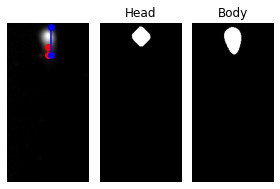

Head length:  35
Tail length:  14
Body length:  49
Comet area:  1062
Comet DNA content:  111862.00000000001
Comet average intensity:  105.33145009416197
Head area:  737
Head DNA content:  93655.0
Head average intensity:  127.07598371777476
Head DNA %:  83.72369526738301
Tail area:  325
Tail DNA content:  18207.000000000015
Tail average intensity:  56.021538461538505
Tail DNA %:  16.276304732616985


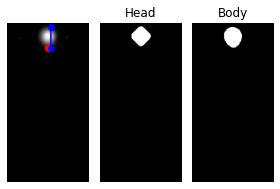

Head length:  35
Tail length:  2
Body length:  37
Comet area:  861
Comet DNA content:  101435.0
Comet average intensity:  117.81068524970964
Head area:  759
Head DNA content:  96109.0
Head average intensity:  126.6258234519104
Head DNA %:  94.74934687238132
Tail area:  102
Tail DNA content:  5326.0
Tail average intensity:  52.21568627450981
Tail DNA %:  5.250653127618672


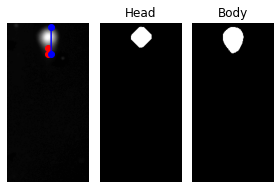

Head length:  37
Tail length:  10
Body length:  47
Comet area:  1226
Comet DNA content:  140541.0
Comet average intensity:  114.63376835236542
Head area:  874
Head DNA content:  121469.0
Head average intensity:  138.98054919908466
Head DNA %:  86.42958282636384
Tail area:  352
Tail DNA content:  19072.0
Tail average intensity:  54.18181818181818
Tail DNA %:  13.570417173636162


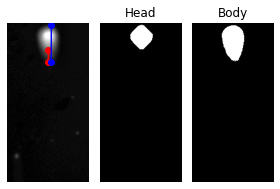

Head length:  43
Tail length:  21
Body length:  64
Comet area:  1840
Comet DNA content:  215785.0
Comet average intensity:  117.27445652173913
Head area:  1130
Head DNA content:  168953.0
Head average intensity:  149.51592920353983
Head DNA %:  78.29691591167133
Tail area:  710
Tail DNA content:  46832.0
Tail average intensity:  65.96056338028168
Tail DNA %:  21.703084088328662


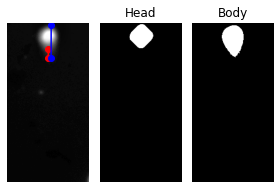

Head length:  42
Tail length:  16
Body length:  58
Comet area:  1508
Comet DNA content:  185598.0
Comet average intensity:  123.07559681697613
Head area:  1162
Head DNA content:  164712.0
Head average intensity:  141.7487091222031
Head DNA %:  88.74664597678854
Tail area:  346
Tail DNA content:  20886.0
Tail average intensity:  60.36416184971098
Tail DNA %:  11.253354023211456


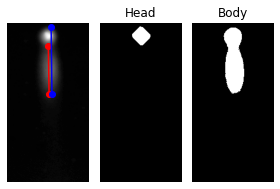

Head length:  33
Tail length:  85
Body length:  118
Comet area:  3071
Comet DNA content:  238706.00000000003
Comet average intensity:  77.72907847606643
Head area:  660
Head DNA content:  81869.0
Head average intensity:  124.0439393939394
Head DNA %:  34.29700133218268
Tail area:  2411
Tail DNA content:  156837.00000000003
Tail average intensity:  65.05060141020324
Tail DNA %:  65.70299866781731


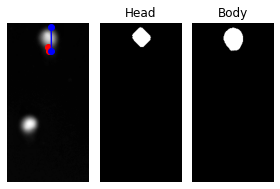

Head length:  35
Tail length:  7
Body length:  42
Comet area:  1051
Comet DNA content:  113969.0
Comet average intensity:  108.43862987630828
Head area:  717
Head DNA content:  95597.0
Head average intensity:  133.32914923291492
Head DNA %:  83.87982697049198
Tail area:  334
Tail DNA content:  18372.0
Tail average intensity:  55.0059880239521
Tail DNA %:  16.120173029508024


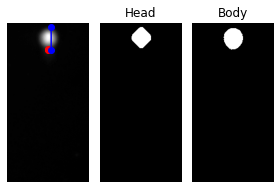

Head length:  37
Tail length:  3
Body length:  40
Comet area:  975
Comet DNA content:  117117.0
Comet average intensity:  120.12
Head area:  833
Head DNA content:  109754.00000000001
Head average intensity:  131.7575030012005
Head DNA %:  93.71312448235525
Tail area:  142
Tail DNA content:  7362.999999999985
Tail average intensity:  51.85211267605624
Tail DNA %:  6.286875517644735


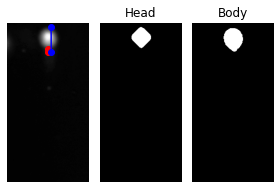

Head length:  37
Tail length:  6
Body length:  43
Comet area:  1025
Comet DNA content:  119207.0
Comet average intensity:  116.29951219512195
Head area:  798
Head DNA content:  106431.00000000001
Head average intensity:  133.37218045112783
Head DNA %:  89.28250857751642
Tail area:  227
Tail DNA content:  12775.999999999985
Tail average intensity:  56.28193832599113
Tail DNA %:  10.717491422483567


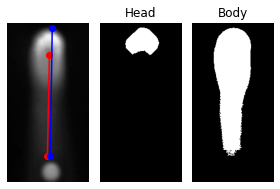

Head length:  48
Tail length:  176
Body length:  224
Comet area:  10063
Comet DNA content:  891127.0000000001
Comet average intensity:  88.55480473019975
Head area:  1961
Head DNA content:  318836.0
Head average intensity:  162.58847526772055
Head DNA %:  35.77896304342703
Tail area:  8102
Tail DNA content:  572291.0000000001
Tail average intensity:  70.63576894593929
Tail DNA %:  64.22103695657297


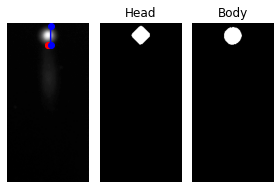

Head length:  33
Tail length:  0
Body length:  33
Comet area:  734
Comet DNA content:  78990.0
Comet average intensity:  107.6158038147139
Head area:  644
Head DNA content:  74643.0
Head average intensity:  115.90527950310559
Head DNA %:  94.49677174325865
Tail area:  90
Tail DNA content:  4347.0
Tail average intensity:  48.3
Tail DNA %:  5.50322825674136


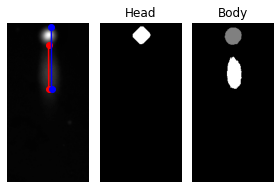

Head length:  31
Tail length:  78
Body length:  109
Comet area:  1788
Comet DNA content:  127170.0
Comet average intensity:  71.1241610738255
Head area:  620
Head DNA content:  70271.0
Head average intensity:  113.34032258064516
Head DNA %:  55.257529291499566
Tail area:  1168
Tail DNA content:  56899.0
Tail average intensity:  48.71489726027397
Tail DNA %:  44.742470708500434


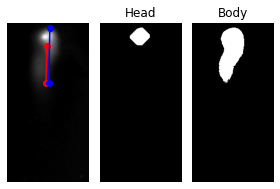

Head length:  31
Tail length:  66
Body length:  97
Comet area:  2797
Comet DNA content:  214184.99999999997
Comet average intensity:  76.57668930997497
Head area:  728
Head DNA content:  96523.0
Head average intensity:  132.58653846153845
Head DNA %:  45.065247332913145
Tail area:  2069
Tail DNA content:  117661.99999999997
Tail average intensity:  56.86901884968582
Tail DNA %:  54.93475266708686


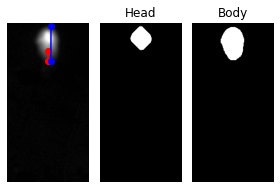

Head length:  43
Tail length:  17
Body length:  60
Comet area:  1779
Comet DNA content:  203443.0
Comet average intensity:  114.35806632939854
Head area:  1007
Head DNA content:  149625.0
Head average intensity:  148.58490566037736
Head DNA %:  73.54639874559459
Tail area:  772
Tail DNA content:  53818.0
Tail average intensity:  69.71243523316062
Tail DNA %:  26.453601254405413


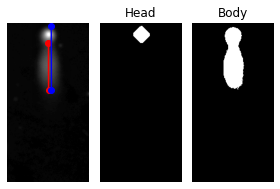

Head length:  30
Tail length:  81
Body length:  111
Comet area:  2947
Comet DNA content:  212199.00000000003
Comet average intensity:  72.00508992195454
Head area:  544
Head DNA content:  64186.0
Head average intensity:  117.98897058823529
Head DNA %:  30.248021903967498
Tail area:  2403
Tail DNA content:  148013.00000000003
Tail average intensity:  61.59508947149398
Tail DNA %:  69.7519780960325


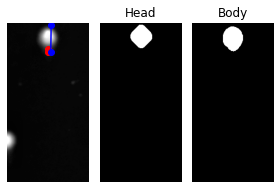

Head length:  41
Tail length:  6
Body length:  47
Comet area:  1158
Comet DNA content:  150138.0
Comet average intensity:  129.65284974093265
Head area:  1065
Head DNA content:  143179.0
Head average intensity:  134.44037558685446
Head DNA %:  95.36493093021086
Tail area:  93
Tail DNA content:  6959.0
Tail average intensity:  74.82795698924731
Tail DNA %:  4.635069069789127


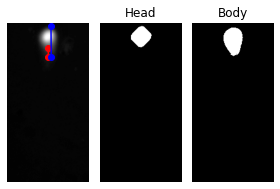

Head length:  38
Tail length:  15
Body length:  53
Comet area:  1236
Comet DNA content:  136399.0
Comet average intensity:  110.3551779935275
Head area:  881
Head DNA content:  115462.0
Head average intensity:  131.05788876276958
Head DNA %:  84.65018071979999
Tail area:  355
Tail DNA content:  20937.0
Tail average intensity:  58.97746478873239
Tail DNA %:  15.349819280200002


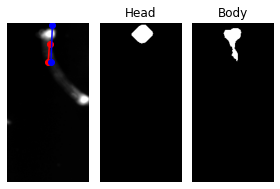

Head length:  33
Tail length:  31
Body length:  64
Comet area:  805
Comet DNA content:  88779.0
Comet average intensity:  110.28447204968944
Head area:  801
Head DNA content:  80092.0
Head average intensity:  99.99001248439451
Head DNA %:  90.21502832877144
Tail area:  4
Tail DNA content:  8687.0
Tail average intensity:  2171.75
Tail DNA %:  9.784971671228556


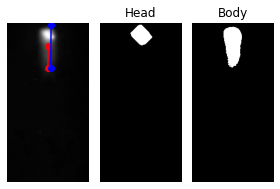

Head length:  36
Tail length:  39
Body length:  75
Comet area:  1692
Comet DNA content:  154165.0
Comet average intensity:  91.11406619385343
Head area:  830
Head DNA content:  103542.0
Head average intensity:  124.74939759036144
Head DNA %:  67.16310446599422
Tail area:  862
Tail DNA content:  50623.0
Tail average intensity:  58.72737819025522
Tail DNA %:  32.83689553400577


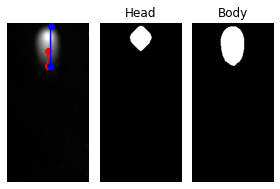

Head length:  44
Tail length:  26
Body length:  70
Comet area:  2245
Comet DNA content:  249521.0
Comet average intensity:  111.14521158129176
Head area:  1082
Head DNA content:  163860.0
Head average intensity:  151.44177449168208
Head DNA %:  65.66982338159914
Tail area:  1163
Tail DNA content:  85661.0
Tail average intensity:  73.65520206362855
Tail DNA %:  34.330176618400856


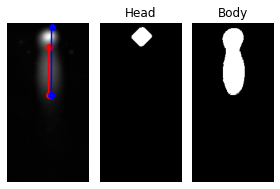

Head length:  34
Tail length:  85
Body length:  119
Comet area:  3652
Comet DNA content:  275895.0
Comet average intensity:  75.54627601314348
Head area:  751
Head DNA content:  99683.0
Head average intensity:  132.73368841544607
Head DNA %:  36.13077438880733
Tail area:  2901
Tail DNA content:  176212.0
Tail average intensity:  60.74181316787315
Tail DNA %:  63.86922561119266


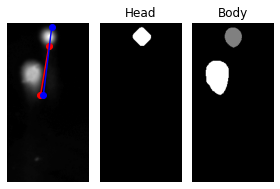

Head length:  33
Tail length:  86
Body length:  119
Comet area:  2661
Comet DNA content:  284562.0
Comet average intensity:  106.93799323562571
Head area:  685
Head DNA content:  83487.0
Head average intensity:  121.87883211678832
Head DNA %:  29.33877327260843
Tail area:  1976
Tail DNA content:  201075.0
Tail average intensity:  101.7586032388664
Tail DNA %:  70.66122672739156


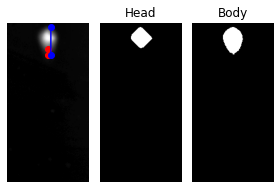

Head length:  37
Tail length:  11
Body length:  48
Comet area:  1173
Comet DNA content:  133168.0
Comet average intensity:  113.52770673486786
Head area:  828
Head DNA content:  113439.00000000001
Head average intensity:  137.0036231884058
Head DNA %:  85.18487925027036
Tail area:  345
Tail DNA content:  19728.999999999985
Tail average intensity:  57.18550724637677
Tail DNA %:  14.815120749729655


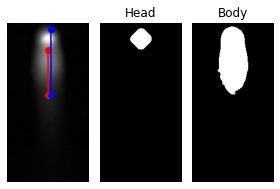

Head length:  38
Tail length:  78
Body length:  116
Comet area:  4733
Comet DNA content:  427342.0
Comet average intensity:  90.28987956898374
Head area:  930
Head DNA content:  137084.0
Head average intensity:  147.4021505376344
Head DNA %:  32.07828858385087
Tail area:  3803
Tail DNA content:  290258.0
Tail average intensity:  76.32342887194321
Tail DNA %:  67.92171141614912


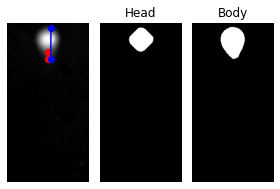

Head length:  42
Tail length:  13
Body length:  55
Comet area:  1711
Comet DNA content:  209648.0
Comet average intensity:  122.52951490356517
Head area:  1205
Head DNA content:  181756.0
Head average intensity:  150.83485477178422
Head DNA %:  86.69579485613981
Tail area:  506
Tail DNA content:  27892.0
Tail average intensity:  55.12252964426877
Tail DNA %:  13.304205143860184


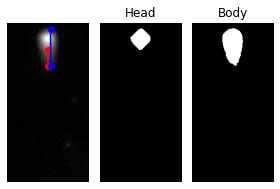

Head length:  38
Tail length:  28
Body length:  66
Comet area:  1733
Comet DNA content:  177083.0
Comet average intensity:  102.18291979226774
Head area:  834
Head DNA content:  119187.00000000001
Head average intensity:  142.91007194244605
Head DNA %:  67.30572669313261
Tail area:  899
Tail DNA content:  57895.999999999985
Tail average intensity:  64.4004449388209
Tail DNA %:  32.694273306867395


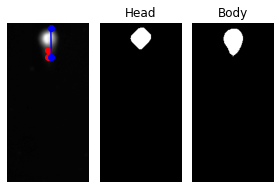

Head length:  38
Tail length:  12
Body length:  50
Comet area:  1144
Comet DNA content:  129427.0
Comet average intensity:  113.1354895104895
Head area:  901
Head DNA content:  116304.0
Head average intensity:  129.0832408435072
Head DNA %:  89.86069367288124
Tail area:  243
Tail DNA content:  13123.0
Tail average intensity:  54.00411522633745
Tail DNA %:  10.139306327118762


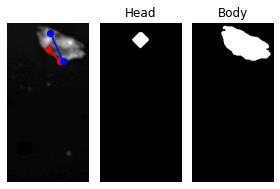

Head length:  28
Tail length:  22
Body length:  50
Comet area:  3187
Comet DNA content:  342356.0
Comet average intensity:  107.42265453404455
Head area:  484
Head DNA content:  68719.0
Head average intensity:  141.98140495867767
Head DNA %:  20.072380796597695
Tail area:  2703
Tail DNA content:  273637.0
Tail average intensity:  101.2345541990381
Tail DNA %:  79.92761920340232


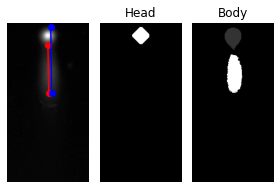

Head length:  30
Tail length:  85
Body length:  115
Comet area:  2172
Comet DNA content:  143904.0
Comet average intensity:  66.25414364640883
Head area:  562
Head DNA content:  64841.0
Head average intensity:  115.37544483985765
Head DNA %:  45.05851122970869
Tail area:  1610
Tail DNA content:  79063.0
Tail average intensity:  49.10745341614907
Tail DNA %:  54.9414887702913


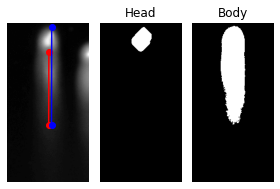

Head length:  43
Tail length:  128
Body length:  171
Comet area:  5795
Comet DNA content:  473258.0
Comet average intensity:  81.66660914581536
Head area:  985
Head DNA content:  143336.0
Head average intensity:  145.51878172588832
Head DNA %:  30.287073858233775
Tail area:  4810
Tail DNA content:  329922.0
Tail average intensity:  68.59085239085239
Tail DNA %:  69.71292614176623


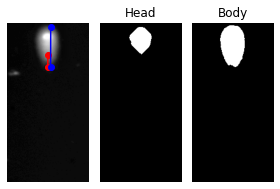

Head length:  48
Tail length:  22
Body length:  70
Comet area:  2445
Comet DNA content:  291462.0
Comet average intensity:  119.20736196319018
Head area:  1248
Head DNA content:  197913.99999999997
Head average intensity:  158.58493589743588
Head DNA %:  67.90387769246075
Tail area:  1197
Tail DNA content:  93548.00000000003
Tail average intensity:  78.15204678362575
Tail DNA %:  32.09612230753925


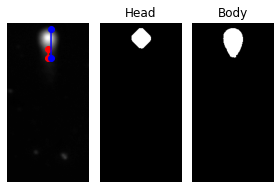

Head length:  36
Tail length:  16
Body length:  52
Comet area:  1314
Comet DNA content:  139114.0
Comet average intensity:  105.87062404870625
Head area:  811
Head DNA content:  111037.0
Head average intensity:  136.91368680641185
Head DNA %:  79.81727216527452
Tail area:  503
Tail DNA content:  28077.0
Tail average intensity:  55.81908548707754
Tail DNA %:  20.182727834725476


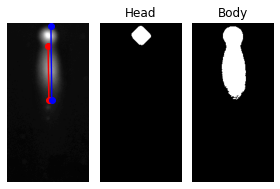

Head length:  34
Tail length:  95
Body length:  129
Comet area:  4068
Comet DNA content:  365419.0
Comet average intensity:  89.82767944936087
Head area:  725
Head DNA content:  97666.0
Head average intensity:  134.71172413793104
Head DNA %:  26.727126941948832
Tail area:  3343
Tail DNA content:  267753.0
Tail average intensity:  80.09362847741549
Tail DNA %:  73.27287305805118


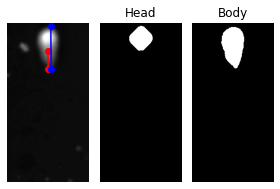

Head length:  44
Tail length:  31
Body length:  75
Comet area:  2084
Comet DNA content:  248590.0
Comet average intensity:  119.28502879078695
Head area:  1202
Head DNA content:  180393.0
Head average intensity:  150.0773710482529
Head DNA %:  72.56647491854056
Tail area:  882
Tail DNA content:  68197.0
Tail average intensity:  77.32086167800453
Tail DNA %:  27.433525081459432


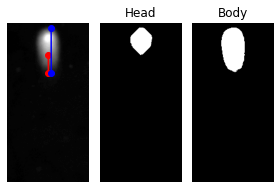

Head length:  48
Tail length:  30
Body length:  78
Comet area:  2562
Comet DNA content:  299274.0
Comet average intensity:  116.81264637002342
Head area:  1261
Head DNA content:  196945.0
Head average intensity:  156.1816019032514
Head DNA %:  65.80758769555658
Tail area:  1301
Tail DNA content:  102329.0
Tail average intensity:  78.65411222136818
Tail DNA %:  34.19241230444342


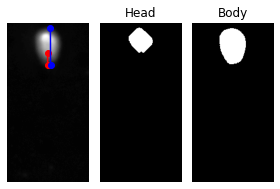

Head length:  44
Tail length:  20
Body length:  64
Comet area:  2293
Comet DNA content:  274936.0
Comet average intensity:  119.90231138246838
Head area:  1232
Head DNA content:  191983.0
Head average intensity:  155.83035714285714
Head DNA %:  69.8282509384002
Tail area:  1061
Tail DNA content:  82953.0
Tail average intensity:  78.18378887841659
Tail DNA %:  30.17174906159979


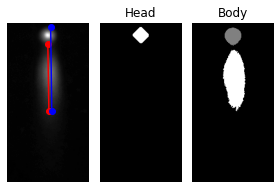

Head length:  29
Tail length:  118
Body length:  147
Comet area:  3591
Comet DNA content:  249611.0
Comet average intensity:  69.51016429963798
Head area:  485
Head DNA content:  53019.0
Head average intensity:  109.31752577319588
Head DNA %:  21.240650452103473
Tail area:  3106
Tail DNA content:  196592.0
Tail average intensity:  63.294269156471344
Tail DNA %:  78.75934954789653


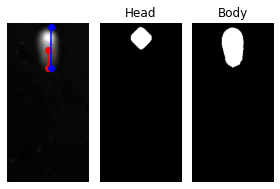

Head length:  40
Tail length:  31
Body length:  71
Comet area:  2096
Comet DNA content:  218015.0
Comet average intensity:  104.01479007633588
Head area:  932
Head DNA content:  133438.0
Head average intensity:  143.17381974248926
Head DNA %:  61.20588032933514
Tail area:  1164
Tail DNA content:  84577.0
Tail average intensity:  72.66065292096219
Tail DNA %:  38.79411967066486


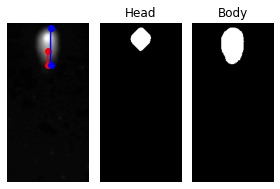

Head length:  41
Tail length:  23
Body length:  64
Comet area:  2013
Comet DNA content:  221597.0
Comet average intensity:  110.0829607550919
Head area:  957
Head DNA content:  142407.0
Head average intensity:  148.80564263322884
Head DNA %:  64.2639566420123
Tail area:  1056
Tail DNA content:  79190.0
Tail average intensity:  74.9905303030303
Tail DNA %:  35.7360433579877


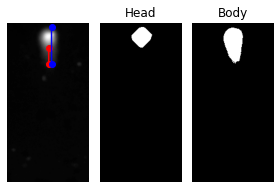

Head length:  36
Tail length:  28
Body length:  64
Comet area:  1528
Comet DNA content:  152290.0
Comet average intensity:  99.66623036649214
Head area:  844
Head DNA content:  112281.99999999999
Head average intensity:  133.03554502369667
Head DNA %:  73.72906953838071
Tail area:  684
Tail DNA content:  40008.000000000015
Tail average intensity:  58.49122807017546
Tail DNA %:  26.27093046161929


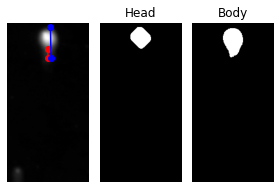

Head length:  38
Tail length:  15
Body length:  53
Comet area:  1269
Comet DNA content:  141207.0
Comet average intensity:  111.274231678487
Head area:  920
Head DNA content:  121911.0
Head average intensity:  132.51195652173914
Head DNA %:  86.334955065967
Tail area:  349
Tail DNA content:  19296.0
Tail average intensity:  55.289398280802295
Tail DNA %:  13.665044934033016


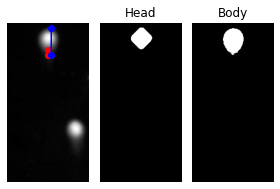

Head length:  38
Tail length:  10
Body length:  48
Comet area:  1218
Comet DNA content:  142400.0
Comet average intensity:  116.91297208538587
Head area:  902
Head DNA content:  124463.00000000001
Head average intensity:  137.98558758314857
Head DNA %:  87.40379213483148
Tail area:  316
Tail DNA content:  17936.999999999985
Tail average intensity:  56.76265822784806
Tail DNA %:  12.59620786516853


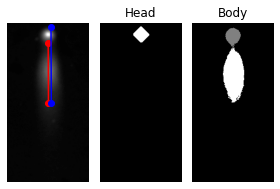

Head length:  28
Tail length:  105
Body length:  133
Comet area:  3109
Comet DNA content:  210543.0
Comet average intensity:  67.7204889031843
Head area:  459
Head DNA content:  47986.0
Head average intensity:  104.54466230936819
Head DNA %:  22.791543770156213
Tail area:  2650
Tail DNA content:  162557.0
Tail average intensity:  61.34226415094339
Tail DNA %:  77.20845622984378


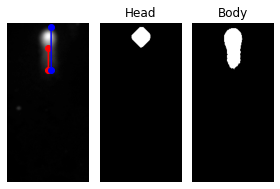

Head length:  36
Tail length:  38
Body length:  74
Comet area:  1676
Comet DNA content:  153064.0
Comet average intensity:  91.32696897374701
Head area:  775
Head DNA content:  100721.0
Head average intensity:  129.9625806451613
Head DNA %:  65.8031934354257
Tail area:  901
Tail DNA content:  52343.0
Tail average intensity:  58.094339622641506
Tail DNA %:  34.196806564574295


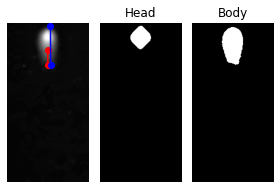

Head length:  41
Tail length:  27
Body length:  68
Comet area:  1866
Comet DNA content:  198893.0
Comet average intensity:  106.58788853161843
Head area:  964
Head DNA content:  135100.0
Head average intensity:  140.14522821576764
Head DNA %:  67.92597024530778
Tail area:  902
Tail DNA content:  63793.0
Tail average intensity:  70.72394678492239
Tail DNA %:  32.074029754692226


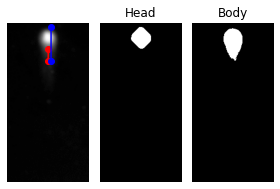

Head length:  38
Tail length:  21
Body length:  59
Comet area:  1303
Comet DNA content:  140221.0
Comet average intensity:  107.61396776669226
Head area:  898
Head DNA content:  116994.0
Head average intensity:  130.28285077951003
Head DNA %:  83.4354340647977
Tail area:  405
Tail DNA content:  23227.0
Tail average intensity:  57.35061728395062
Tail DNA %:  16.56456593520229


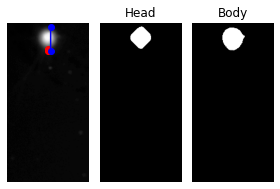

Head length:  39
Tail length:  3
Body length:  42
Comet area:  1133
Comet DNA content:  134564.0
Comet average intensity:  118.76787290379524
Head area:  927
Head DNA content:  124285.99999999999
Head average intensity:  134.07335490830636
Head DNA %:  92.36199875152343
Tail area:  206
Tail DNA content:  10278.000000000015
Tail average intensity:  49.89320388349522
Tail DNA %:  7.638001248476573


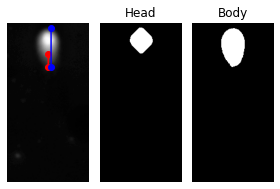

Head length:  46
Tail length:  23
Body length:  69
Comet area:  2129
Comet DNA content:  246466.0
Comet average intensity:  115.76608736496007
Head area:  1187
Head DNA content:  181014.0
Head average intensity:  152.49705139005897
Head DNA %:  73.44380157912248
Tail area:  942
Tail DNA content:  65452.0
Tail average intensity:  69.48195329087049
Tail DNA %:  26.556198420877525


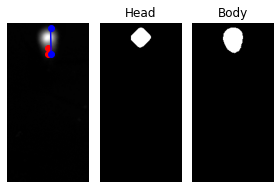

Head length:  35
Tail length:  10
Body length:  45
Comet area:  1192
Comet DNA content:  128020.0
Comet average intensity:  107.3993288590604
Head area:  795
Head DNA content:  106115.00000000001
Head average intensity:  133.47798742138366
Head DNA %:  82.88939228245587
Tail area:  397
Tail DNA content:  21904.999999999985
Tail average intensity:  55.17632241813598
Tail DNA %:  17.11060771754412


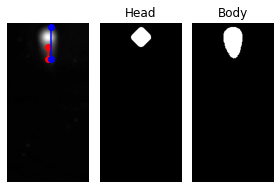

Head length:  35
Tail length:  20
Body length:  55
Comet area:  1396
Comet DNA content:  142416.0
Comet average intensity:  102.01719197707736
Head area:  783
Head DNA content:  106885.0
Head average intensity:  136.50702426564496
Head DNA %:  75.05125828558589
Tail area:  613
Tail DNA content:  35531.0
Tail average intensity:  57.96247960848287
Tail DNA %:  24.948741714414112


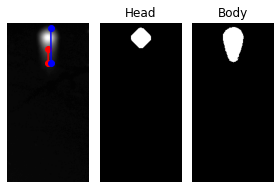

Head length:  36
Tail length:  25
Body length:  61
Comet area:  1619
Comet DNA content:  162917.0
Comet average intensity:  100.62816553428043
Head area:  835
Head DNA content:  117199.0
Head average intensity:  140.35808383233532
Head DNA %:  71.93785792765641
Tail area:  784
Tail DNA content:  45718.0
Tail average intensity:  58.31377551020408
Tail DNA %:  28.062142072343587


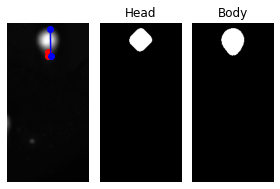

Head length:  41
Tail length:  7
Body length:  48
Comet area:  1420
Comet DNA content:  173104.0
Comet average intensity:  121.90422535211268
Head area:  1075
Head DNA content:  155364.0
Head average intensity:  144.5246511627907
Head DNA %:  89.75182549218967
Tail area:  345
Tail DNA content:  17740.0
Tail average intensity:  51.42028985507246
Tail DNA %:  10.248174507810335


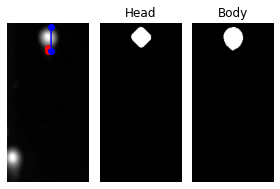

Head length:  36
Tail length:  5
Body length:  41
Comet area:  1027
Comet DNA content:  121948.0
Comet average intensity:  118.74196689386562
Head area:  815
Head DNA content:  110915.99999999999
Head average intensity:  136.09325153374232
Head DNA %:  90.95352117295896
Tail area:  212
Tail DNA content:  11032.000000000015
Tail average intensity:  52.03773584905667
Tail DNA %:  9.046478827041046


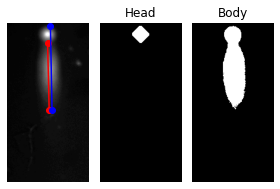

Head length:  30
Tail length:  116
Body length:  146
Comet area:  4220
Comet DNA content:  339437.0
Comet average intensity:  80.43530805687203
Head area:  549
Head DNA content:  67307.0
Head average intensity:  122.59927140255009
Head DNA %:  19.829010979946204
Tail area:  3671
Tail DNA content:  272130.0
Tail average intensity:  74.12966494143285
Tail DNA %:  80.1709890200538


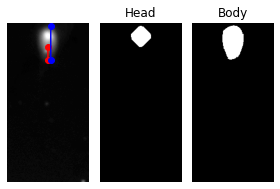

Head length:  37
Tail length:  22
Body length:  59
Comet area:  1728
Comet DNA content:  183102.0
Comet average intensity:  105.96180555555556
Head area:  852
Head DNA content:  122056.0
Head average intensity:  143.2582159624413
Head DNA %:  66.66011294251291
Tail area:  876
Tail DNA content:  61046.0
Tail average intensity:  69.68721461187215
Tail DNA %:  33.33988705748708


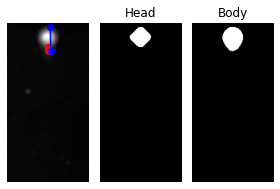

Head length:  35
Tail length:  7
Body length:  42
Comet area:  1143
Comet DNA content:  131658.0
Comet average intensity:  115.18635170603675
Head area:  853
Head DNA content:  116773.0
Head average intensity:  136.8968347010551
Head DNA %:  88.6941925291285
Tail area:  290
Tail DNA content:  14885.0
Tail average intensity:  51.327586206896555
Tail DNA %:  11.3058074708715


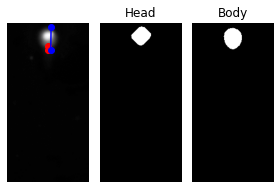

Head length:  34
Tail length:  6
Body length:  40
Comet area:  905
Comet DNA content:  99185.0
Comet average intensity:  109.59668508287292
Head area:  748
Head DNA content:  88648.0
Head average intensity:  118.51336898395722
Head DNA %:  89.37641780511166
Tail area:  157
Tail DNA content:  10537.0
Tail average intensity:  67.11464968152866
Tail DNA %:  10.623582194888339


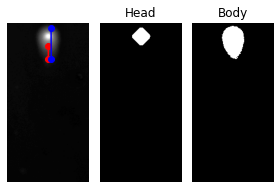

Head length:  31
Tail length:  24
Body length:  55
Comet area:  1647
Comet DNA content:  150016.0
Comet average intensity:  91.08439587128112
Head area:  625
Head DNA content:  85894.0
Head average intensity:  137.4304
Head DNA %:  57.256559300341294
Tail area:  1022
Tail DNA content:  64122.0
Tail average intensity:  62.74168297455969
Tail DNA %:  42.743440699658706


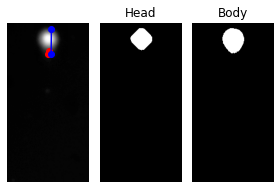

Head length:  39
Tail length:  5
Body length:  44
Comet area:  1256
Comet DNA content:  152395.0
Comet average intensity:  121.33359872611464
Head area:  985
Head DNA content:  138825.0
Head average intensity:  140.93908629441626
Head DNA %:  91.09550838282095
Tail area:  271
Tail DNA content:  13570.0
Tail average intensity:  50.07380073800738
Tail DNA %:  8.904491617179042


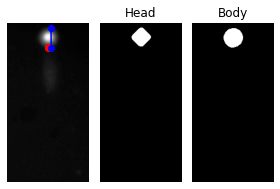

Head length:  33
Tail length:  2
Body length:  35
Comet area:  893
Comet DNA content:  96793.0
Comet average intensity:  108.39081746920493
Head area:  710
Head DNA content:  88002.0
Head average intensity:  123.94647887323944
Head DNA %:  90.91773165414855
Tail area:  183
Tail DNA content:  8791.0
Tail average intensity:  48.03825136612022
Tail DNA %:  9.082268345851457


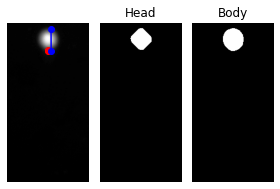

Head length:  38
Tail length:  2
Body length:  40
Comet area:  1124
Comet DNA content:  139646.0
Comet average intensity:  124.24021352313167
Head area:  931
Head DNA content:  129895.99999999999
Head average intensity:  139.52309344790547
Head DNA %:  93.01805995159187
Tail area:  193
Tail DNA content:  9750.000000000015
Tail average intensity:  50.51813471502598
Tail DNA %:  6.981940048408128


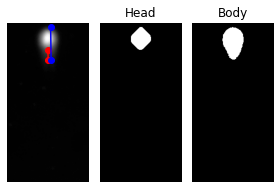

Head length:  40
Tail length:  17
Body length:  57
Comet area:  1520
Comet DNA content:  164829.0
Comet average intensity:  108.44013157894737
Head area:  942
Head DNA content:  133521.0
Head average intensity:  141.7420382165605
Head DNA %:  81.00576961578363
Tail area:  578
Tail DNA content:  31308.0
Tail average intensity:  54.16608996539792
Tail DNA %:  18.994230384216372


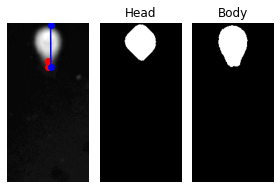

Head length:  64
Tail length:  11
Body length:  75
Comet area:  2721
Comet DNA content:  409798.99999999994
Comet average intensity:  150.60602719588385
Head area:  2358
Head DNA content:  384616.0
Head average intensity:  163.11111111111111
Head DNA %:  93.85479222740905
Tail area:  363
Tail DNA content:  25182.99999999994
Tail average intensity:  69.37465564738277
Tail DNA %:  6.14520777259094


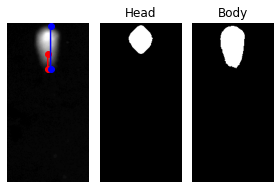

Head length:  50
Tail length:  25
Body length:  75
Comet area:  2396
Comet DNA content:  300281.0
Comet average intensity:  125.32595993322204
Head area:  1406
Head DNA content:  222582.99999999997
Head average intensity:  158.3093883357041
Head DNA %:  74.12490300751628
Tail area:  990
Tail DNA content:  77698.00000000003
Tail average intensity:  78.48282828282831
Tail DNA %:  25.875096992483716


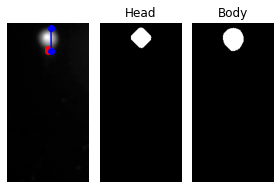

Head length:  36
Tail length:  5
Body length:  41
Comet area:  1113
Comet DNA content:  129315.0
Comet average intensity:  116.18598382749326
Head area:  821
Head DNA content:  113594.00000000001
Head average intensity:  138.3605359317905
Head DNA %:  87.84286432355103
Tail area:  292
Tail DNA content:  15720.999999999985
Tail average intensity:  53.83904109589036
Tail DNA %:  12.15713567644897


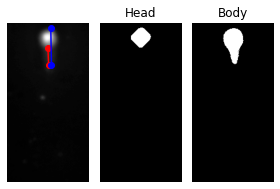

Head length:  35
Tail length:  29
Body length:  64
Comet area:  1380
Comet DNA content:  134642.0
Comet average intensity:  97.56666666666666
Head area:  795
Head DNA content:  105260.99999999999
Head average intensity:  132.40377358490565
Head DNA %:  78.17842872209265
Tail area:  585
Tail DNA content:  29381.000000000015
Tail average intensity:  50.22393162393165
Tail DNA %:  21.82157127790735


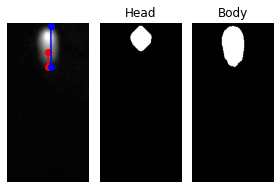

Head length:  45
Tail length:  27
Body length:  72
Comet area:  2183
Comet DNA content:  247167.0
Comet average intensity:  113.22354557947779
Head area:  1110
Head DNA content:  166548.0
Head average intensity:  150.04324324324324
Head DNA %:  67.38278168202065
Tail area:  1073
Tail DNA content:  80619.0
Tail average intensity:  75.13420316868593
Tail DNA %:  32.617218317979344


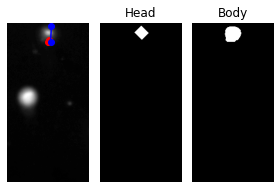

Head length:  24
Tail length:  4
Body length:  28
Comet area:  635
Comet DNA content:  48940.0
Comet average intensity:  77.07086614173228
Head area:  312
Head DNA content:  32688.0
Head average intensity:  104.76923076923077
Head DNA %:  66.79199019207192
Tail area:  323
Tail DNA content:  16252.0
Tail average intensity:  50.31578947368421
Tail DNA %:  33.20800980792807


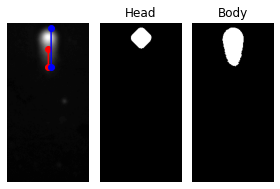

Head length:  37
Tail length:  31
Body length:  68
Comet area:  1866
Comet DNA content:  183843.0
Comet average intensity:  98.52250803858522
Head area:  868
Head DNA content:  121569.0
Head average intensity:  140.05645161290323
Head DNA %:  66.12653187774352
Tail area:  998
Tail DNA content:  62274.0
Tail average intensity:  62.39879759519038
Tail DNA %:  33.87346812225649


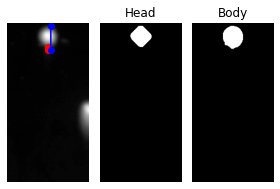

Head length:  37
Tail length:  4
Body length:  41
Comet area:  1089
Comet DNA content:  134051.0
Comet average intensity:  123.09550045913683
Head area:  897
Head DNA content:  124198.00000000001
Head average intensity:  138.4593088071349
Head DNA %:  92.64981238483861
Tail area:  192
Tail DNA content:  9852.999999999985
Tail average intensity:  51.31770833333326
Tail DNA %:  7.350187615161382


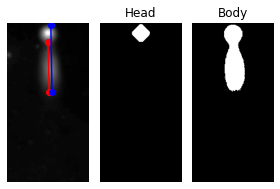

Head length:  31
Tail length:  87
Body length:  118
Comet area:  3159
Comet DNA content:  249361.0
Comet average intensity:  78.93668882557772
Head area:  623
Head DNA content:  79185.0
Head average intensity:  127.10272873194222
Head DNA %:  31.755166204819517
Tail area:  2536
Tail DNA content:  170176.0
Tail average intensity:  67.10410094637224
Tail DNA %:  68.24483379518048


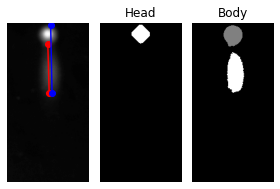

Head length:  33
Tail length:  86
Body length:  119
Comet area:  2510
Comet DNA content:  185082.0
Comet average intensity:  73.7378486055777
Head area:  675
Head DNA content:  85189.0
Head average intensity:  126.20592592592592
Head DNA %:  46.027706638138774
Tail area:  1835
Tail DNA content:  99893.0
Tail average intensity:  54.43760217983651
Tail DNA %:  53.97229336186123


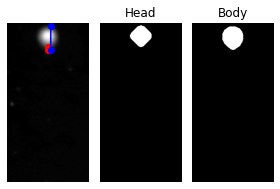

Head length:  38
Tail length:  5
Body length:  43
Comet area:  1150
Comet DNA content:  140693.0
Comet average intensity:  122.34173913043479
Head area:  946
Head DNA content:  129569.00000000001
Head average intensity:  136.96511627906978
Head DNA %:  92.09342326910365
Tail area:  204
Tail DNA content:  11123.999999999985
Tail average intensity:  54.52941176470581
Tail DNA %:  7.9065767308963375


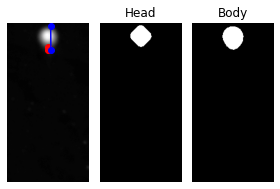

Head length:  38
Tail length:  5
Body length:  43
Comet area:  1134
Comet DNA content:  136953.0
Comet average intensity:  120.76984126984127
Head area:  927
Head DNA content:  125762.99999999999
Head average intensity:  135.66666666666666
Head DNA %:  91.82931370616195
Tail area:  207
Tail DNA content:  11190.000000000015
Tail average intensity:  54.05797101449282
Tail DNA %:  8.170686293838042


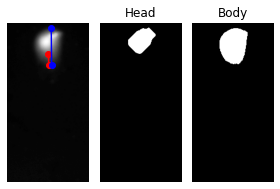

Head length:  46
Tail length:  18
Body length:  64
Comet area:  2410
Comet DNA content:  274649.0
Comet average intensity:  113.96224066390042
Head area:  1380
Head DNA content:  207897.0
Head average intensity:  150.65
Head DNA %:  75.6955241053126
Tail area:  1030
Tail DNA content:  66752.0
Tail average intensity:  64.80776699029126
Tail DNA %:  24.304475894687403


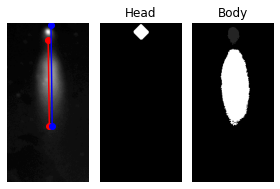

Head length:  27
Tail length:  151
Body length:  178
Comet area:  5317
Comet DNA content:  426395.0
Comet average intensity:  80.19465864209141
Head area:  427
Head DNA content:  33511.0
Head average intensity:  78.48009367681499
Head DNA %:  7.859144689782947
Tail area:  4890
Tail DNA content:  392884.0
Tail average intensity:  80.3443762781186
Tail DNA %:  92.14085531021705


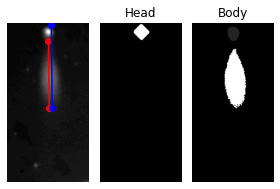

Head length:  28
Tail length:  119
Body length:  147
Comet area:  3061
Comet DNA content:  221561.99999999997
Comet average intensity:  72.38222803005553
Head area:  455
Head DNA content:  39496.0
Head average intensity:  86.80439560439561
Head DNA %:  17.826161525893433
Tail area:  2606
Tail DNA content:  182065.99999999997
Tail average intensity:  69.86415963161933
Tail DNA %:  82.17383847410656


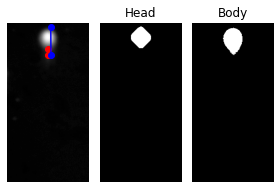

Head length:  38
Tail length:  12
Body length:  50
Comet area:  1125
Comet DNA content:  131707.0
Comet average intensity:  117.07288888888888
Head area:  887
Head DNA content:  118317.00000000001
Head average intensity:  133.39007891770012
Head DNA %:  89.83349404359679
Tail area:  238
Tail DNA content:  13389.999999999985
Tail average intensity:  56.26050420168061
Tail DNA %:  10.166505956403217


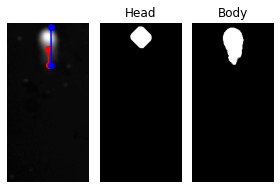

Head length:  38
Tail length:  29
Body length:  67
Comet area:  1634
Comet DNA content:  170632.0
Comet average intensity:  104.42594859241126
Head area:  934
Head DNA content:  128507.0
Head average intensity:  137.58779443254818
Head DNA %:  75.31236813727789
Tail area:  700
Tail DNA content:  42125.0
Tail average intensity:  60.17857142857143
Tail DNA %:  24.687631862722114


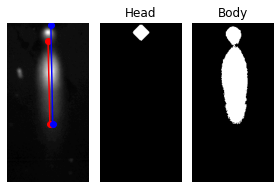

Head length:  28
Tail length:  146
Body length:  174
Comet area:  5394
Comet DNA content:  483046.0
Comet average intensity:  89.55246570263256
Head area:  471
Head DNA content:  47593.0
Head average intensity:  101.04670912951168
Head DNA %:  9.852684837468894
Tail area:  4923
Tail DNA content:  435453.0
Tail average intensity:  88.45277269957343
Tail DNA %:  90.1473151625311


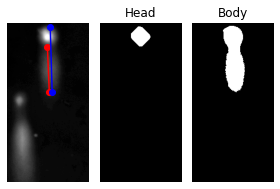

Head length:  35
Tail length:  80
Body length:  115
Comet area:  3171
Comet DNA content:  243705.0
Comet average intensity:  76.8543046357616
Head area:  777
Head DNA content:  103637.0
Head average intensity:  133.38095238095238
Head DNA %:  42.52559446872243
Tail area:  2394
Tail DNA content:  140068.0
Tail average intensity:  58.507936507936506
Tail DNA %:  57.474405531277576


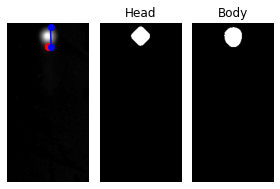

Head length:  34
Tail length:  2
Body length:  36
Comet area:  842
Comet DNA content:  94174.0
Comet average intensity:  111.84560570071258
Head area:  721
Head DNA content:  87771.0
Head average intensity:  121.73509015256587
Head DNA %:  93.20088347102173
Tail area:  121
Tail DNA content:  6403.0
Tail average intensity:  52.917355371900825
Tail DNA %:  6.799116528978274


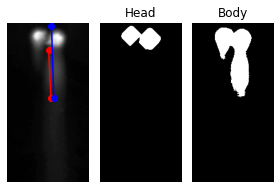

Head length:  42
Tail length:  83
Body length:  125
Comet area:  4277
Comet DNA content:  364091.0
Comet average intensity:  85.12765957446808
Head area:  1721
Head DNA content:  222412.00000000003
Head average intensity:  129.23416618245207
Head DNA %:  61.086926070680136
Tail area:  2556
Tail DNA content:  141678.99999999997
Tail average intensity:  55.42996870109545
Tail DNA %:  38.91307392931986


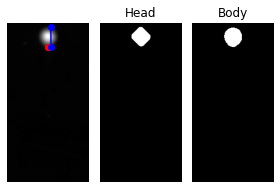

Head length:  34
Tail length:  1
Body length:  35
Comet area:  814
Comet DNA content:  95905.0
Comet average intensity:  117.81941031941032
Head area:  727
Head DNA content:  91475.0
Head average intensity:  125.82530949105914
Head DNA %:  95.38084562848653
Tail area:  87
Tail DNA content:  4430.0
Tail average intensity:  50.91954022988506
Tail DNA %:  4.619154371513477


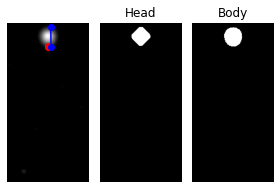

Head length:  33
Tail length:  1
Body length:  34
Comet area:  833
Comet DNA content:  97071.0
Comet average intensity:  116.53181272509003
Head area:  709
Head DNA content:  90511.0
Head average intensity:  127.66008462623414
Head DNA %:  93.24205993551112
Tail area:  124
Tail DNA content:  6560.0
Tail average intensity:  52.903225806451616
Tail DNA %:  6.75794006448888


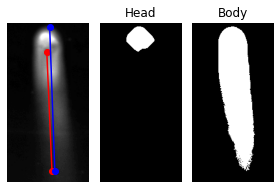

Head length:  44
Tail length:  209
Body length:  253
Comet area:  10819
Comet DNA content:  982322.0
Comet average intensity:  90.7960070246788
Head area:  1422
Head DNA content:  217279.00000000003
Head average intensity:  152.79817158931084
Head DNA %:  22.118918236586378
Tail area:  9397
Tail DNA content:  765043.0
Tail average intensity:  81.4135362349686
Tail DNA %:  77.88108176341363


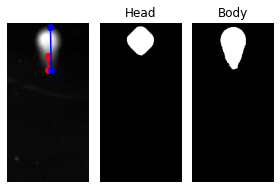

Head length:  51
Tail length:  24
Body length:  75
Comet area:  2316
Comet DNA content:  302700.99999999994
Comet average intensity:  130.69991364421415
Head area:  1639
Head DNA content:  256778.00000000003
Head average intensity:  156.6674801708359
Head DNA %:  84.82892359126666
Tail area:  677
Tail DNA content:  45922.99999999991
Tail average intensity:  67.83308714918746
Tail DNA %:  15.171076408733345


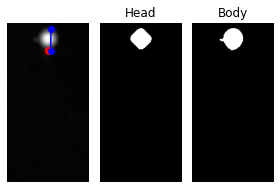

Head length:  37
Tail length:  2
Body length:  39
Comet area:  1034
Comet DNA content:  125571.0
Comet average intensity:  121.44197292069633
Head area:  907
Head DNA content:  119716.99999999999
Head average intensity:  131.9922822491731
Head DNA %:  95.33809557939333
Tail area:  127
Tail DNA content:  5854.000000000015
Tail average intensity:  46.09448818897649
Tail DNA %:  4.66190442060668


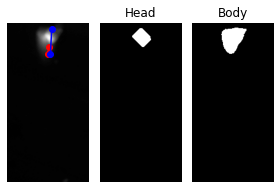

Head length:  33
Tail length:  12
Body length:  45
Comet area:  1341
Comet DNA content:  125568.99999999999
Comet average intensity:  93.63832960477255
Head area:  644
Head DNA content:  84211.0
Head average intensity:  130.76242236024845
Head DNA %:  67.06352682588856
Tail area:  697
Tail DNA content:  41357.999999999985
Tail average intensity:  59.33715925394546
Tail DNA %:  32.936473174111434


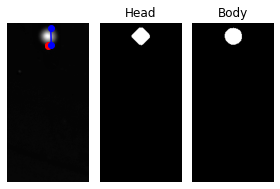

Head length:  30
Tail length:  0
Body length:  30
Comet area:  700
Comet DNA content:  78526.0
Comet average intensity:  112.18
Head area:  623
Head DNA content:  74538.0
Head average intensity:  119.64365971107544
Head DNA %:  94.921427297965
Tail area:  77
Tail DNA content:  3988.0
Tail average intensity:  51.79220779220779
Tail DNA %:  5.078572702034995


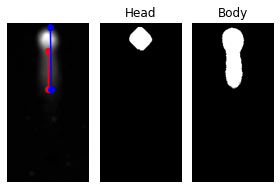

Head length:  41
Tail length:  67
Body length:  108
Comet area:  2911
Comet DNA content:  258821.0
Comet average intensity:  88.9113706630024
Head area:  1088
Head DNA content:  155039.0
Head average intensity:  142.49908088235293
Head DNA %:  59.90201722425924
Tail area:  1823
Tail DNA content:  103782.0
Tail average intensity:  56.92923752057049
Tail DNA %:  40.09798277574077


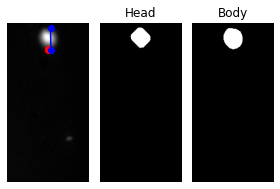

Head length:  36
Tail length:  2
Body length:  38
Comet area:  966
Comet DNA content:  114326.0
Comet average intensity:  118.34989648033127
Head area:  822
Head DNA content:  107026.0
Head average intensity:  130.20194647201947
Head DNA %:  93.61475080034289
Tail area:  144
Tail DNA content:  7300.0
Tail average intensity:  50.69444444444444
Tail DNA %:  6.385249199657121


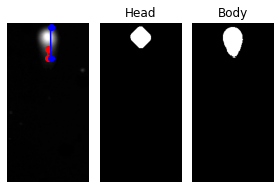

Head length:  38
Tail length:  17
Body length:  55
Comet area:  1346
Comet DNA content:  150749.0
Comet average intensity:  111.99777117384843
Head area:  912
Head DNA content:  126673.00000000001
Head average intensity:  138.89583333333334
Head DNA %:  84.02908145327665
Tail area:  434
Tail DNA content:  24075.999999999985
Tail average intensity:  55.47465437788015
Tail DNA %:  15.97091854672335


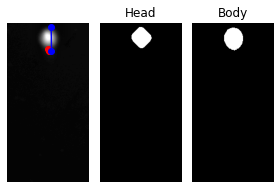

Head length:  37
Tail length:  4
Body length:  41
Comet area:  1011
Comet DNA content:  120653.0
Comet average intensity:  119.3402571711177
Head area:  862
Head DNA content:  112987.99999999999
Head average intensity:  131.07656612529001
Head DNA %:  93.64707052456215
Tail area:  149
Tail DNA content:  7665.000000000015
Tail average intensity:  51.442953020134325
Tail DNA %:  6.352929475437838


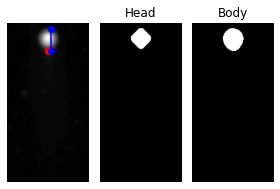

Head length:  37
Tail length:  3
Body length:  40
Comet area:  1092
Comet DNA content:  127827.0
Comet average intensity:  117.0576923076923
Head area:  837
Head DNA content:  114673.99999999999
Head average intensity:  137.00597371565112
Head DNA %:  89.71031159301242
Tail area:  255
Tail DNA content:  13153.000000000015
Tail average intensity:  51.5803921568628
Tail DNA %:  10.289688406987581


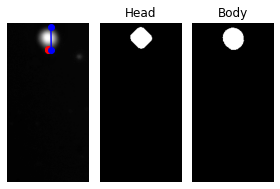

Head length:  38
Tail length:  2
Body length:  40
Comet area:  1106
Comet DNA content:  136387.0
Comet average intensity:  123.31555153707052
Head area:  949
Head DNA content:  128530.99999999999
Head average intensity:  135.43835616438355
Head DNA %:  94.2399202270011
Tail area:  157
Tail DNA content:  7856.000000000015
Tail average intensity:  50.038216560509646
Tail DNA %:  5.760079772998903


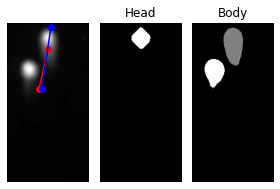

Head length:  38
Tail length:  69
Body length:  107
Comet area:  2970
Comet DNA content:  314038.0
Comet average intensity:  105.73670033670034
Head area:  807
Head DNA content:  110752.0
Head average intensity:  137.23915737298637
Head DNA %:  35.26706959030436
Tail area:  2163
Tail DNA content:  203286.0
Tail average intensity:  93.98335644937586
Tail DNA %:  64.73293040969564


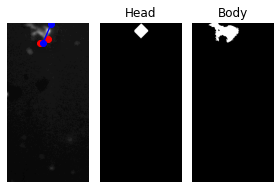

Head length:  26
Tail length:  7
Body length:  33
Comet area:  909
Comet DNA content:  69066.0
Comet average intensity:  75.98019801980197
Head area:  348
Head DNA content:  30019.0
Head average intensity:  86.26149425287356
Head DNA %:  43.46422262763154
Tail area:  561
Tail DNA content:  39047.0
Tail average intensity:  69.60249554367202
Tail DNA %:  56.53577737236846


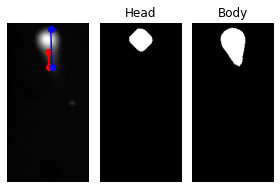

Head length:  41
Tail length:  26
Body length:  67
Comet area:  2000
Comet DNA content:  217308.0
Comet average intensity:  108.654
Head area:  1108
Head DNA content:  166470.0
Head average intensity:  150.24368231046932
Head DNA %:  76.60555524877132
Tail area:  892
Tail DNA content:  50838.0
Tail average intensity:  56.993273542600896
Tail DNA %:  23.394444751228672


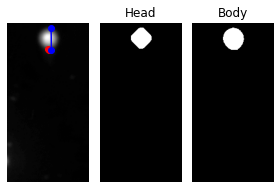

Head length:  37
Tail length:  2
Body length:  39
Comet area:  1092
Comet DNA content:  133078.0
Comet average intensity:  121.86630036630036
Head area:  906
Head DNA content:  123764.0
Head average intensity:  136.60485651214128
Head DNA %:  93.00109710094831
Tail area:  186
Tail DNA content:  9314.0
Tail average intensity:  50.075268817204304
Tail DNA %:  6.998902899051684


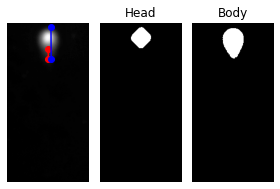

Head length:  37
Tail length:  18
Body length:  55
Comet area:  1426
Comet DNA content:  150176.0
Comet average intensity:  105.31276297335204
Head area:  850
Head DNA content:  116885.99999999999
Head average intensity:  137.51294117647058
Head DNA %:  77.83267632644363
Tail area:  576
Tail DNA content:  33290.000000000015
Tail average intensity:  57.795138888888914
Tail DNA %:  22.167323673556368


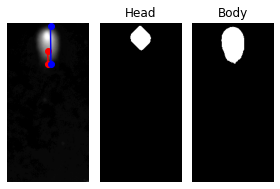

Head length:  43
Tail length:  23
Body length:  66
Comet area:  1976
Comet DNA content:  224707.0
Comet average intensity:  113.71811740890688
Head area:  985
Head DNA content:  147680.0
Head average intensity:  149.9289340101523
Head DNA %:  65.72113908333964
Tail area:  991
Tail DNA content:  77027.0
Tail average intensity:  77.72653884964681
Tail DNA %:  34.27886091666036


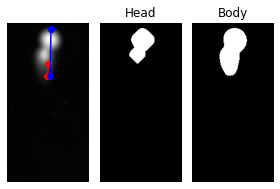

Head length:  62
Tail length:  21
Body length:  83
Comet area:  2673
Comet DNA content:  307164.0
Comet average intensity:  114.91358024691358
Head area:  1672
Head DNA content:  248024.00000000003
Head average intensity:  148.3397129186603
Head DNA %:  80.7464416402964
Tail area:  1001
Tail DNA content:  59139.99999999997
Tail average intensity:  59.08091908091905
Tail DNA %:  19.2535583597036


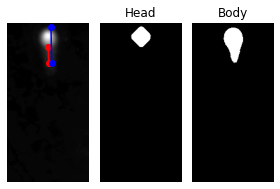

Head length:  36
Tail length:  28
Body length:  64
Comet area:  1366
Comet DNA content:  134057.0
Comet average intensity:  98.13836017569547
Head area:  795
Head DNA content:  104804.0
Head average intensity:  131.82893081761006
Head DNA %:  78.17868518615217
Tail area:  571
Tail DNA content:  29253.0
Tail average intensity:  51.231173380035024
Tail DNA %:  21.82131481384784


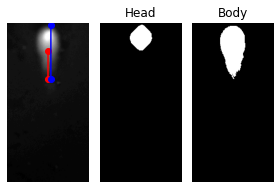

Head length:  45
Tail length:  50
Body length:  95
Comet area:  2807
Comet DNA content:  303257.0
Comet average intensity:  108.03598147488422
Head area:  1194
Head DNA content:  183472.0
Head average intensity:  153.66164154103853
Head DNA %:  60.500499576266996
Tail area:  1613
Tail DNA content:  119785.0
Tail average intensity:  74.26224426534408
Tail DNA %:  39.499500423733004


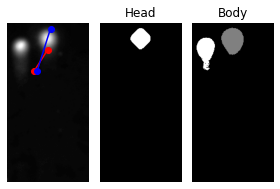

Head length:  37
Tail length:  37
Body length:  74
Comet area:  2506
Comet DNA content:  260816.0
Comet average intensity:  104.07661612130886
Head area:  863
Head DNA content:  120766.0
Head average intensity:  139.93742757821553
Head DNA %:  46.303140911600515
Tail area:  1643
Tail DNA content:  140050.0
Tail average intensity:  85.24041387705417
Tail DNA %:  53.696859088399485


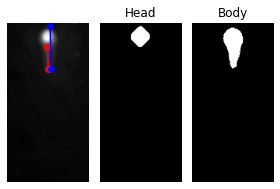

Head length:  37
Tail length:  38
Body length:  75
Comet area:  1561
Comet DNA content:  136935.0
Comet average intensity:  87.7226137091608
Head area:  808
Head DNA content:  99802.0
Head average intensity:  123.51732673267327
Head DNA %:  72.88275459159456
Tail area:  753
Tail DNA content:  37133.0
Tail average intensity:  49.31341301460824
Tail DNA %:  27.11724540840545


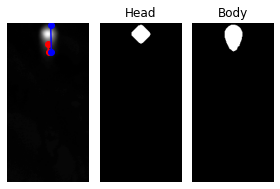

Head length:  33
Tail length:  14
Body length:  47
Comet area:  1070
Comet DNA content:  107215.0
Comet average intensity:  100.20093457943925
Head area:  676
Head DNA content:  85538.0
Head average intensity:  126.53550295857988
Head DNA %:  79.78174695704891
Tail area:  394
Tail DNA content:  21677.0
Tail average intensity:  55.01776649746193
Tail DNA %:  20.21825304295108


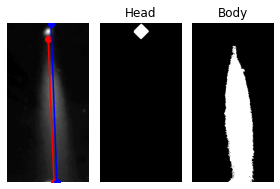

Head length:  27
Tail length:  250
Body length:  277
Comet area:  8435
Comet DNA content:  516817.0
Comet average intensity:  61.270539419087136
Head area:  401
Head DNA content:  29517.0
Head average intensity:  73.60847880299252
Head DNA %:  5.7113059361437415
Tail area:  8034
Tail DNA content:  487300.0
Tail average intensity:  60.65471745083396
Tail DNA %:  94.28869406385625


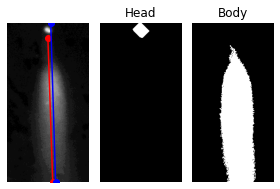

Head length:  26
Tail length:  252
Body length:  278
Comet area:  10911
Comet DNA content:  802924.0
Comet average intensity:  73.58848868114747
Head area:  449
Head DNA content:  28871.999999999996
Head average intensity:  64.30289532293986
Head DNA %:  3.595857142145458
Tail area:  10462
Tail DNA content:  774052.0
Tail average intensity:  73.9870005735041
Tail DNA %:  96.40414285785455


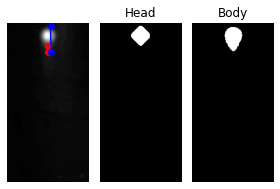

Head length:  35
Tail length:  10
Body length:  45
Comet area:  924
Comet DNA content:  101339.0
Comet average intensity:  109.67424242424242
Head area:  729
Head DNA content:  90932.0
Head average intensity:  124.7352537722908
Head DNA %:  89.73050849130148
Tail area:  195
Tail DNA content:  10407.0
Tail average intensity:  53.36923076923077
Tail DNA %:  10.269491508698527


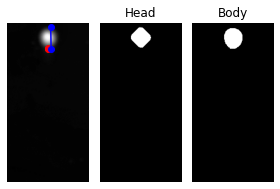

Head length:  36
Tail length:  2
Body length:  38
Comet area:  921
Comet DNA content:  110190.0
Comet average intensity:  119.64169381107492
Head area:  814
Head DNA content:  104549.0
Head average intensity:  128.43857493857493
Head DNA %:  94.88066067701243
Tail area:  107
Tail DNA content:  5641.0
Tail average intensity:  52.7196261682243
Tail DNA %:  5.119339322987567


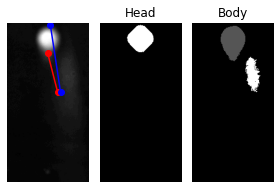

Head length:  48
Tail length:  70
Body length:  118
Comet area:  2812
Comet DNA content:  288516.0
Comet average intensity:  102.60170697012802
Head area:  1507
Head DNA content:  227135.0
Head average intensity:  150.71997345719973
Head DNA %:  78.72527000235688
Tail area:  1305
Tail DNA content:  61381.0
Tail average intensity:  47.035249042145594
Tail DNA %:  21.27472999764311


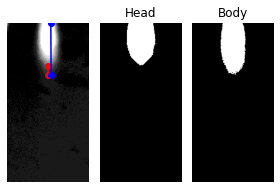

Head length:  74
Tail length:  16
Body length:  90
Comet area:  3282
Comet DNA content:  559214.0
Comet average intensity:  170.38817794028031
Head area:  3022
Head DNA content:  526746.0
Head average intensity:  174.30377233620118
Head DNA %:  94.19399371260376
Tail area:  260
Tail DNA content:  32468.0
Tail average intensity:  124.87692307692308
Tail DNA %:  5.806006287396238


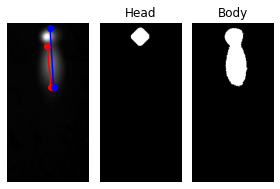

Head length:  32
Tail length:  71
Body length:  103
Comet area:  2923
Comet DNA content:  225778.0
Comet average intensity:  77.24187478617858
Head area:  670
Head DNA content:  75439.0
Head average intensity:  112.5955223880597
Head DNA %:  33.41291002666336
Tail area:  2253
Tail DNA content:  150339.0
Tail average intensity:  66.728362183755
Tail DNA %:  66.58708997333665


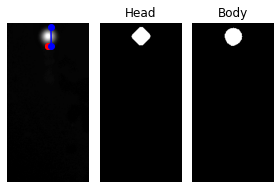

Head length:  32
Tail length:  1
Body length:  33
Comet area:  726
Comet DNA content:  83699.0
Comet average intensity:  115.28787878787878
Head area:  674
Head DNA content:  80865.0
Head average intensity:  119.97774480712167
Head DNA %:  96.61405751562145
Tail area:  52
Tail DNA content:  2834.0
Tail average intensity:  54.5
Tail DNA %:  3.385942484378547


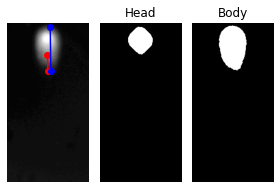

Head length:  49
Tail length:  28
Body length:  77
Comet area:  2889
Comet DNA content:  348814.0
Comet average intensity:  120.73866389754241
Head area:  1451
Head DNA content:  237980.00000000003
Head average intensity:  164.01102687801517
Head DNA %:  68.22547260144376
Tail area:  1438
Tail DNA content:  110833.99999999997
Tail average intensity:  77.0751043115438
Tail DNA %:  31.77452739855624


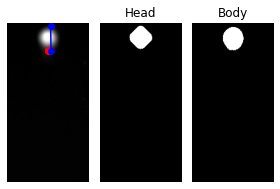

Head length:  41
Tail length:  2
Body length:  43
Comet area:  1140
Comet DNA content:  149229.0
Comet average intensity:  130.90263157894736
Head area:  1073
Head DNA content:  144790.0
Head average intensity:  134.9394221808015
Head DNA %:  97.0253771049863
Tail area:  67
Tail DNA content:  4439.0
Tail average intensity:  66.25373134328358
Tail DNA %:  2.9746228950137037


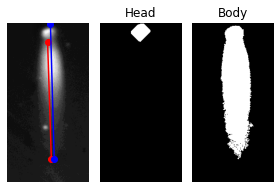

Head length:  32
Tail length:  205
Body length:  237
Comet area:  8985
Comet DNA content:  882732.0
Comet average intensity:  98.24507512520869
Head area:  668
Head DNA content:  76320.0
Head average intensity:  114.25149700598803
Head DNA %:  8.64588572749147
Tail area:  8317
Tail DNA content:  806412.0
Tail average intensity:  96.95948058194061
Tail DNA %:  91.35411427250854


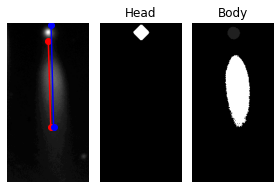

Head length:  27
Tail length:  152
Body length:  179
Comet area:  4278
Comet DNA content:  282532.0
Comet average intensity:  66.04301075268818
Head area:  441
Head DNA content:  37027.0
Head average intensity:  83.96145124716553
Head DNA %:  13.105418147324905
Tail area:  3837
Tail DNA content:  245505.0
Tail average intensity:  63.98358092259578
Tail DNA %:  86.89458185267509


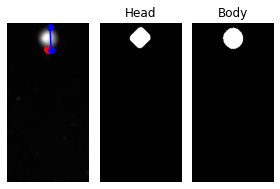

Head length:  37
Tail length:  2
Body length:  39
Comet area:  992
Comet DNA content:  120972.0
Comet average intensity:  121.9475806451613
Head area:  859
Head DNA content:  113168.0
Head average intensity:  131.74388824214202
Head DNA %:  93.54892041133486
Tail area:  133
Tail DNA content:  7804.0
Tail average intensity:  58.67669172932331
Tail DNA %:  6.451079588665146


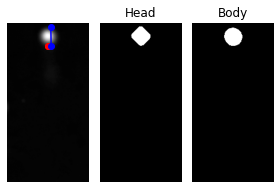

Head length:  34
Tail length:  0
Body length:  34
Comet area:  784
Comet DNA content:  91261.0
Comet average intensity:  116.40433673469387
Head area:  727
Head DNA content:  88062.0
Head average intensity:  121.13067400275104
Head DNA %:  96.49466913577541
Tail area:  57
Tail DNA content:  3199.0
Tail average intensity:  56.12280701754386
Tail DNA %:  3.5053308642245864


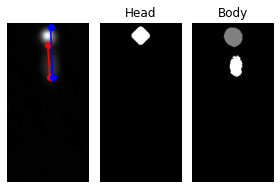

Head length:  32
Tail length:  56
Body length:  88
Comet area:  1478
Comet DNA content:  116768.0
Comet average intensity:  79.00405953991881
Head area:  657
Head DNA content:  79093.0
Head average intensity:  120.38508371385083
Head DNA %:  67.73516716908742
Tail area:  821
Tail DNA content:  37675.0
Tail average intensity:  45.889159561510354
Tail DNA %:  32.264832830912574


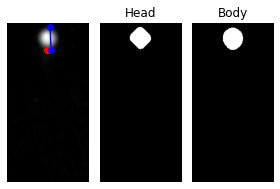

Head length:  39
Tail length:  1
Body length:  40
Comet area:  1058
Comet DNA content:  133065.0
Comet average intensity:  125.7703213610586
Head area:  950
Head DNA content:  127357.0
Head average intensity:  134.06
Head DNA %:  95.71036711381655
Tail area:  108
Tail DNA content:  5708.0
Tail average intensity:  52.851851851851855
Tail DNA %:  4.289632886183444


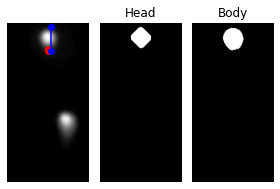

Head length:  37
Tail length:  4
Body length:  41
Comet area:  1061
Comet DNA content:  123099.00000000001
Comet average intensity:  116.02167766258248
Head area:  841
Head DNA content:  112007.99999999999
Head average intensity:  133.18430439952436
Head DNA %:  90.99017863670701
Tail area:  220
Tail DNA content:  11091.00000000003
Tail average intensity:  50.4136363636365
Tail DNA %:  9.009821363292982


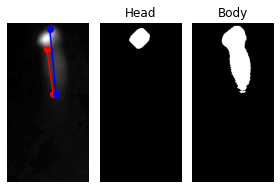

Head length:  36
Tail length:  78
Body length:  114
Comet area:  3491
Comet DNA content:  260877.0
Comet average intensity:  74.72844457175594
Head area:  868
Head DNA content:  118572.99999999999
Head average intensity:  136.6048387096774
Head DNA %:  45.45168796022646
Tail area:  2623
Tail DNA content:  142304.0
Tail average intensity:  54.2523827678231
Tail DNA %:  54.54831203977353


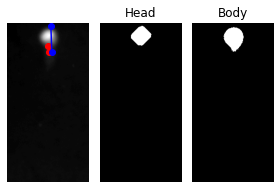

Head length:  35
Tail length:  10
Body length:  45
Comet area:  1029
Comet DNA content:  114829.0
Comet average intensity:  111.59280855199222
Head area:  792
Head DNA content:  101299.0
Head average intensity:  127.90277777777777
Head DNA %:  88.21726218986493
Tail area:  237
Tail DNA content:  13530.0
Tail average intensity:  57.08860759493671
Tail DNA %:  11.782737810135071


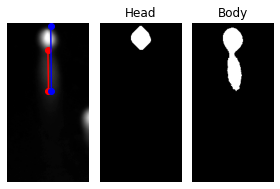

Head length:  42
Tail length:  72
Body length:  114
Comet area:  2342
Comet DNA content:  192878.0
Comet average intensity:  82.35610589239965
Head area:  968
Head DNA content:  129001.00000000001
Head average intensity:  133.2654958677686
Head DNA %:  66.88217422412094
Tail area:  1374
Tail DNA content:  63876.999999999985
Tail average intensity:  46.48981077147015
Tail DNA %:  33.11782577587905


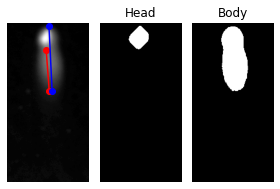

Head length:  41
Tail length:  73
Body length:  114
Comet area:  4110
Comet DNA content:  372139.0
Comet average intensity:  90.54476885644769
Head area:  933
Head DNA content:  132327.0
Head average intensity:  141.82958199356912
Head DNA %:  35.558487554381564
Tail area:  3177
Tail DNA content:  239812.0
Tail average intensity:  75.48378973874725
Tail DNA %:  64.44151244561844


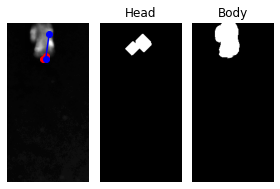

Head length:  38
Tail length:  5
Body length:  43
Comet area:  2099
Comet DNA content:  223423.0
Comet average intensity:  106.44259171033826
Head area:  887
Head DNA content:  103085.0
Head average intensity:  116.21758737316799
Head DNA %:  46.13893824718136
Tail area:  1212
Tail DNA content:  120338.0
Tail average intensity:  99.2887788778878
Tail DNA %:  53.86106175281864


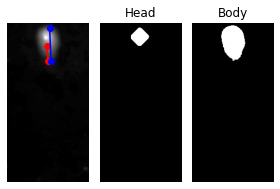

Head length:  32
Tail length:  26
Body length:  58
Comet area:  1897
Comet DNA content:  186981.0
Comet average intensity:  98.56668423827095
Head area:  641
Head DNA content:  94537.0
Head average intensity:  147.48361934477379
Head DNA %:  50.55968253458908
Tail area:  1256
Tail DNA content:  92444.0
Tail average intensity:  73.60191082802548
Tail DNA %:  49.44031746541093


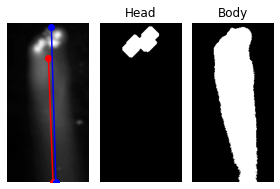

Head length:  55
Tail length:  217
Body length:  272
Comet area:  14343
Comet DNA content:  995596.0000000001
Comet average intensity:  69.41337237676916
Head area:  1846
Head DNA content:  255634.0
Head average intensity:  138.47995666305525
Head DNA %:  25.67647921446048
Tail area:  12497
Tail DNA content:  739962.0000000001
Tail average intensity:  59.21117068096344
Tail DNA %:  74.32352078553951


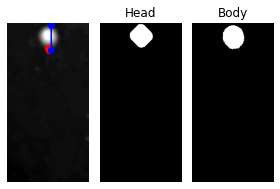

Head length:  41
Tail length:  3
Body length:  44
Comet area:  1209
Comet DNA content:  160562.0
Comet average intensity:  132.80562448304383
Head area:  1117
Head DNA content:  154960.0
Head average intensity:  138.72873769024173
Head DNA %:  96.5110050946052
Tail area:  92
Tail DNA content:  5602.0
Tail average intensity:  60.891304347826086
Tail DNA %:  3.488994905394801


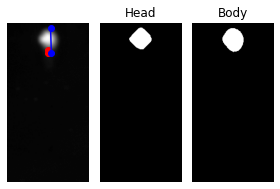

Head length:  38
Tail length:  5
Body length:  43
Comet area:  1131
Comet DNA content:  139223.0
Comet average intensity:  123.0972590627763
Head area:  964
Head DNA content:  130413.99999999999
Head average intensity:  135.28423236514521
Head DNA %:  93.67274085460016
Tail area:  167
Tail DNA content:  8809.000000000015
Tail average intensity:  52.748502994012064
Tail DNA %:  6.327259145399837


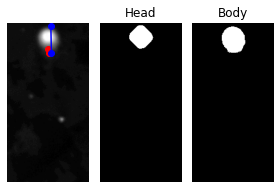

Head length:  41
Tail length:  7
Body length:  48
Comet area:  1474
Comet DNA content:  184955.0
Comet average intensity:  125.47829036635007
Head area:  1154
Head DNA content:  165764.0
Head average intensity:  143.64298093587522
Head DNA %:  89.62396258549377
Tail area:  320
Tail DNA content:  19191.0
Tail average intensity:  59.971875
Tail DNA %:  10.37603741450623


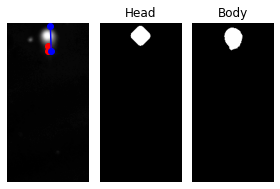

Head length:  35
Tail length:  8
Body length:  43
Comet area:  909
Comet DNA content:  102986.0
Comet average intensity:  113.2959295929593
Head area:  778
Head DNA content:  94391.0
Head average intensity:  121.32519280205655
Head DNA %:  91.65420542598022
Tail area:  131
Tail DNA content:  8595.0
Tail average intensity:  65.61068702290076
Tail DNA %:  8.34579457401977


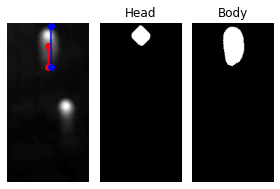

Head length:  36
Tail length:  36
Body length:  72
Comet area:  2010
Comet DNA content:  183946.0
Comet average intensity:  91.51542288557214
Head area:  756
Head DNA content:  99844.0
Head average intensity:  132.06878306878306
Head DNA %:  54.27897317691062
Tail area:  1254
Tail DNA content:  84102.0
Tail average intensity:  67.06698564593302
Tail DNA %:  45.72102682308938


In [9]:
#calculate comet measures 
all_stats, all_img = comet_measure(filtered_info, plot_graph = True)
all_img=np.array(all_img)

In [10]:
print("Total comets processed: ", len(all_img))

Total comets processed:  151


### Outputs

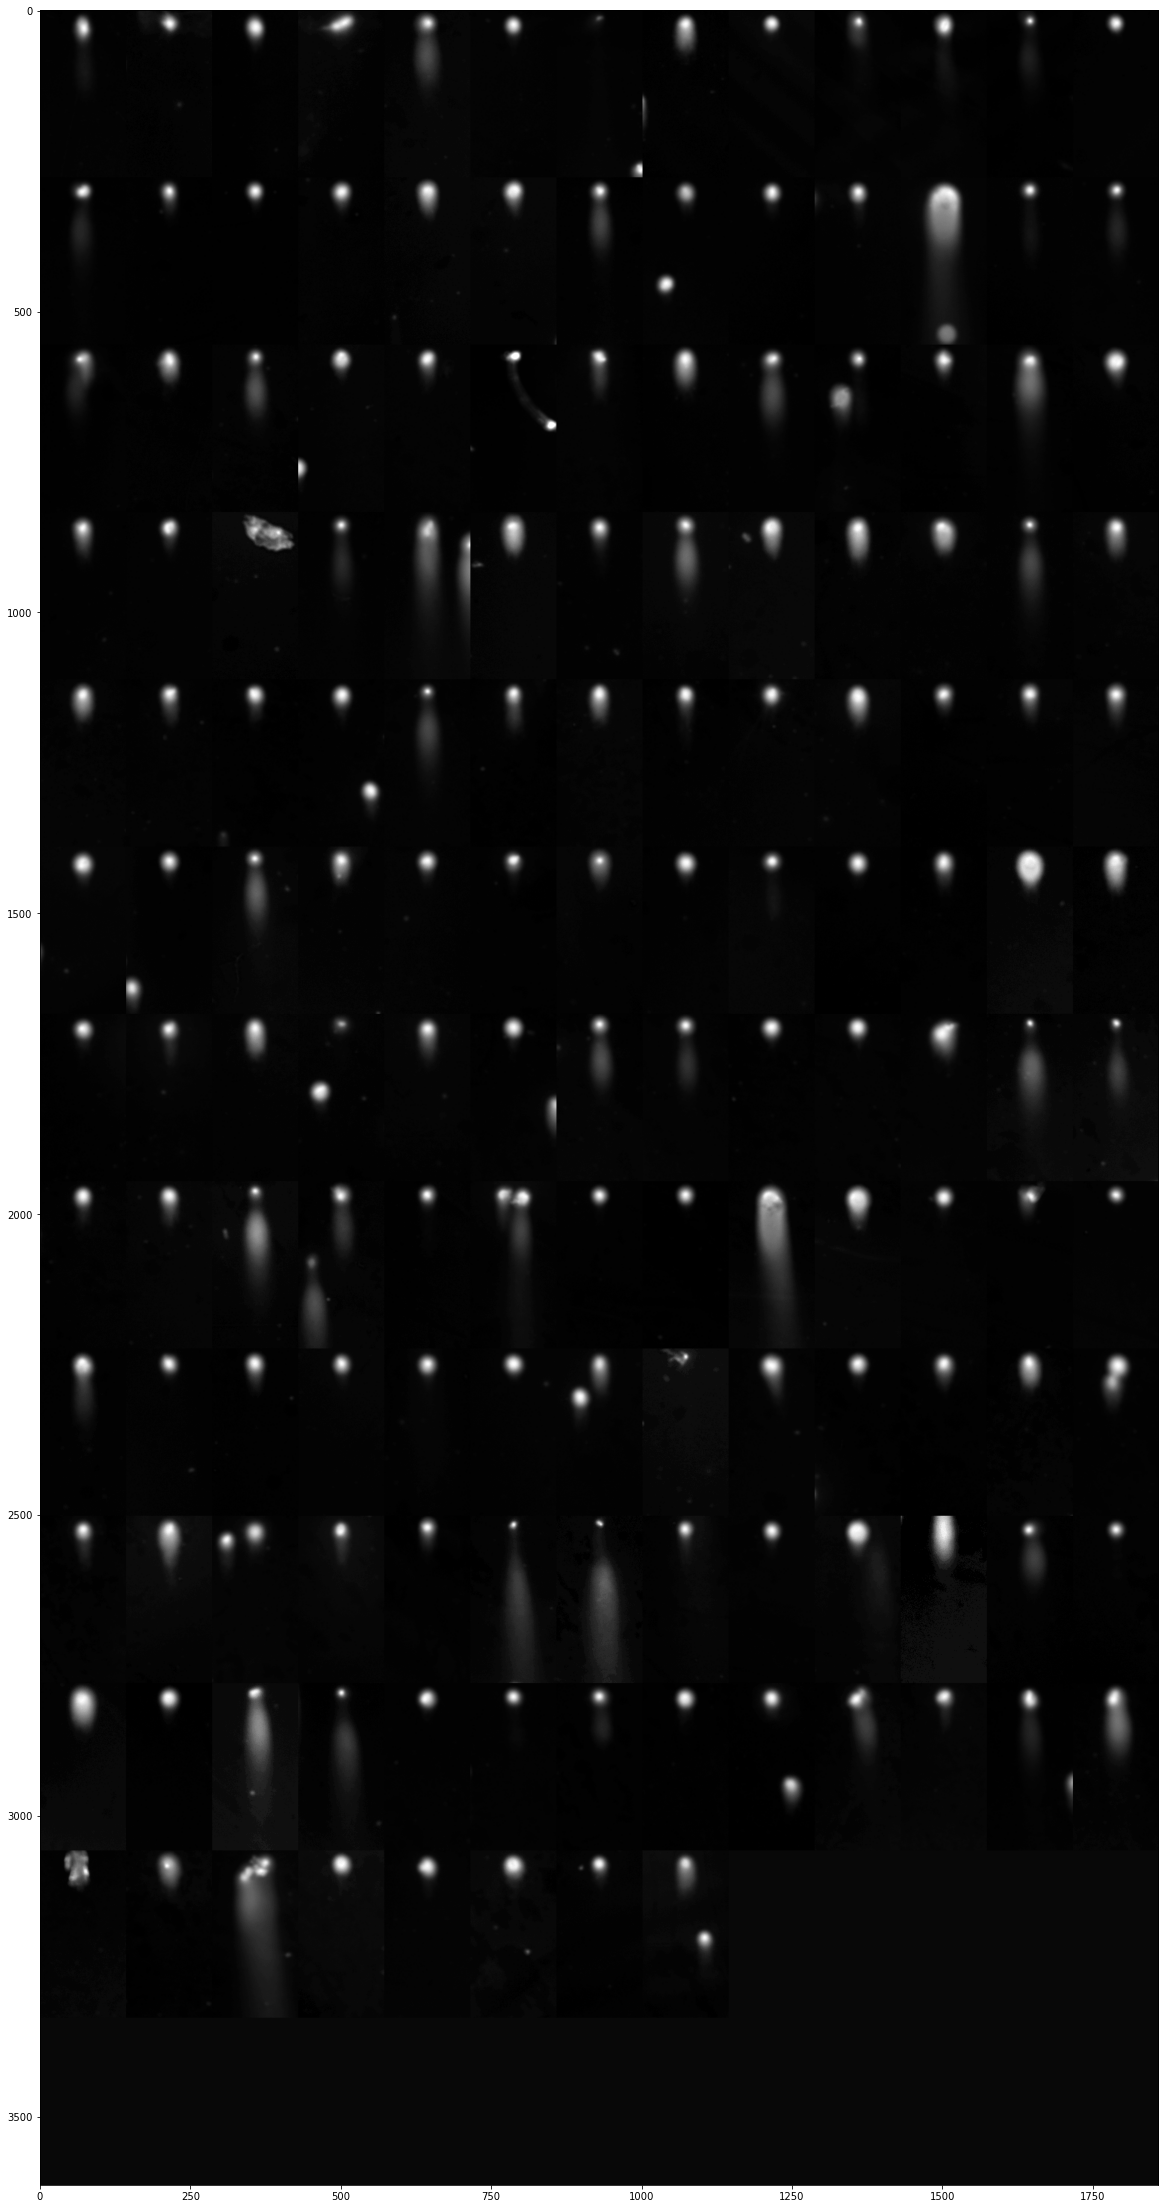

In [11]:
#montage of comets
class_montage(all_img,40,40,rescale=True)

In [12]:
if not os.path.exists(output_path):
    os.makedirs(output_path)

#output montage
im = Image.fromarray(montage(np.array(all_img),rescale_intensity=True))
im.save(os.path.join(output_path,'montage_comets.png'))

#output crops 
for (img,file) in zip(all_img, all_stats):
    name = file[0].split('/')[-1]
    filename = name.split('.')[0]
    cell = file[1]

    cv2.imwrite(os.path.join(output_path,filename+'_'+str(cell)+'.png'), img)
    
#Ouput csv
df = pd.DataFrame(all_stats, columns=['filename', 'cell', 'head length', 'tail length', 'body length','comet area', 
                                      'comet dna content', 'comet avg intensity','head area', 'head dna content', 'head avg intensity',
                                      'head dna percentage', 'tail area', 'tail dna content','tail average','tail dna percentage'])

df.to_csv(os.path.join(output_path,'comet_measurements.csv'),index=False)
